# Traffic in Ontario

Ensuring that people and goods are moved safely across Ontario is one of the major objectives of Ontario’s Ministry of Transportation (MTO). To this end, the ministry often conducts surveys of goods, goods value, passengers and vehicular movement across its five regions around the province.

In this project, we examined the survey data provided by the MTO at certain spots in the province of Ontario. The data provided spans only a two-week period in the year of 2008. The aim was to derive a few key insights about vehicular movement in the province by extending this small sample in order to make generalizations about the state of traffic in Ontario. The sample contains over 17000 records and 13 attributes; it seems adequate enough to derive insights about its population. Some of the questions examined, in no particular order, include:

1. Which station records the highest volume of traffic? What proportion of vehicles makes up the highest traffic volume?
2. Which highway experiences the highest traffic volume? What proportion of vehicles makes up the highest traffic volume?
3. What does the daily traffic distribution for each station look like?
4. Which MTO region has the highest traffic?
5. On what day of the week is the highest traffic volume registered?
6. What are the chances of getting stuck in traffic in Toronto downtown when returning from work at 1600hrs in the afternoon?
7. What is the best time to leave home for work, if working in downtown Toronto? Are there possible favorable alternative routes?
8. Can we possibly apply clustering to this dataset to see the highway most affected by traffic?

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns=20
%matplotlib inline

Read data into pandas `DataFrame` and rename columns.

In [3]:
# Read the csv file into notebook as a pandas dataframe
data = pd.read_csv('https://files.ontario.ca/opendata/2006_commercial_vehicle_survey_-_traffic_volumes_at_survey_stations.csv', 
                  header=0, names=['stationID', 'stationName', 'direction', 'MTORegion', 'highway', 'locationDescription',
                                  'dayWeekNo', 'hour', 'single', 'multi', 'auto', 'totalTrucks', 'totalVehicles'])

### Data Preparation and Visualization

#### How do the data types look?

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17472 entries, 0 to 17471
Data columns (total 13 columns):
stationID              17472 non-null object
stationName            17472 non-null object
direction              17472 non-null object
MTORegion              17472 non-null object
highway                17472 non-null object
locationDescription    17472 non-null object
dayWeekNo              17472 non-null int64
hour                   17472 non-null int64
single                 17472 non-null int64
multi                  17472 non-null int64
auto                   17472 non-null int64
totalTrucks            17472 non-null int64
totalVehicles          17472 non-null int64
dtypes: int64(7), object(6)
memory usage: 1.7+ MB


Most of the attribute types are already correctly deciphered by Pandas. The other `object` datatypes are all `string` types, but their existing form seems okay for analysis.

Next we check if the data set contains any null data.

#### Are there null values in the data set? What are some of the attributes of each column?

In [5]:
data.isnull().sum()

stationID              0
stationName            0
direction              0
MTORegion              0
highway                0
locationDescription    0
dayWeekNo              0
hour                   0
single                 0
multi                  0
auto                   0
totalTrucks            0
totalVehicles          0
dtype: int64

There are also no null values in the data set.

We use the `describe` function to take a look at some of the statistics (and distribution) of the data set. The data has 17,472 records. We also see from examining `std` against the `mean` of the individual attributes that the spread of the attributes seem to be quite a lot. This suggests that the data could be heavily skewed or spread over a huge interval. It could also contain a significant number of outliers. The value of the `75%` percentile for every data is orders of magnitude less than the maximum value.

In [6]:
data.describe()

,dayWeekNo,hour,single,multi,auto,totalTrucks,totalVehicles
count,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000
mean,4.000000,11.500000,20.133700,62.056090,644.548420,82.198890,726.739870
std,2.000057,6.922385,54.301801,112.808261,1576.759504,159.512693,1698.481144
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,5.750000,2.000000,6.000000,52.000000,9.000000,70.000000
50%,4.000000,11.500000,6.000000,16.000000,156.000000,22.000000,190.000000
75%,6.000000,17.250000,13.000000,52.000000,400.000000,67.000000,490.000000
max,7.000000,23.000000,674.000000,961.000000,13168.000000,1587.000000,14092.000000


In [7]:
data.head()

,stationID,stationName,direction,MTORegion,highway,locationDescription,dayWeekNo,hour,single,multi,auto,totalTrucks,totalVehicles
0,ON0016,Bowmanville (West/Ouest: Kingston - Toronto),West,Central,Hwy 401,"On Highway 401, between Bennett Rd (Exit 435) ...",1,0,7,31,302,38,340
1,ON0016,Bowmanville (West/Ouest: Kingston - Toronto),West,Central,Hwy 401,"On Highway 401, between Bennett Rd (Exit 435) ...",1,1,9,22,170,31,201
2,ON0016,Bowmanville (West/Ouest: Kingston - Toronto),West,Central,Hwy 401,"On Highway 401, between Bennett Rd (Exit 435) ...",1,2,0,23,124,23,147
3,ON0016,Bowmanville (West/Ouest: Kingston - Toronto),West,Central,Hwy 401,"On Highway 401, between Bennett Rd (Exit 435) ...",1,3,9,31,85,40,125
4,ON0016,Bowmanville (West/Ouest: Kingston - Toronto),West,Central,Hwy 401,"On Highway 401, between Bennett Rd (Exit 435) ...",1,4,9,27,114,36,150


There are 33 unique `highway` values in the data set, 104 unique `stationID` values and 5 unique `MTORegions`. 
In addition, it appears ,contrary to the information in the data set metadata, there is actually only a week of data available in the data set.

`stationID` identifies the id of the traffic monitoring station. `stationName` is the name of the station. `direction` provides the direction of traffic at any one time, while `MTORegion` provides one of the five Ontario MTO regions. `locationDescription` describes the location of traffic, often specifying a stretch of the `highway` where the traffic was logged. `dayWeekNo` and `hour` are the week day and hour respectively during this the record was collected. `single`, `multi`, `auto` and `totalTrucks` specifies the number of single unit trucks, multi unit trucks, auto or passenger vehicles and total number of trucks (sum of `single` and `multi` units). `totalVehicles` provides the sum total of auto and truck traffic.

In [8]:
print('Number of unique highway values are: {}\n\
Number of unique station values are: {}\nNumber of unique MTO Regions are: {}'
      .format(data['highway'].nunique(), data['stationID'].nunique(), data['MTORegion'].nunique()))

Number of unique highway values are: 33
Number of unique station values are: 104
Number of unique MTO Regions are: 5


In [9]:
data[data.stationID == 'ON0016'].dayWeekNo.unique()

array([1, 2, 3, 4, 5, 6, 7], dtype=int64)

Next, we examine histograms of the respective quantitative data available in the data set. The histograms confirm the skewness in the distribution of the data. All share somewhat similar distributions and have more data count at lower values than at higher values. The vehicle traffic data for all categories of vehicle is heavily right-skewed. This is because there is much less traffic present on more days and hours than there is heavy traffic on others. This makes sure all the histogramsp produce data which is congregated on one side of the chart. We could also employ a log scale in gaining better insight into the nature of the distribution.

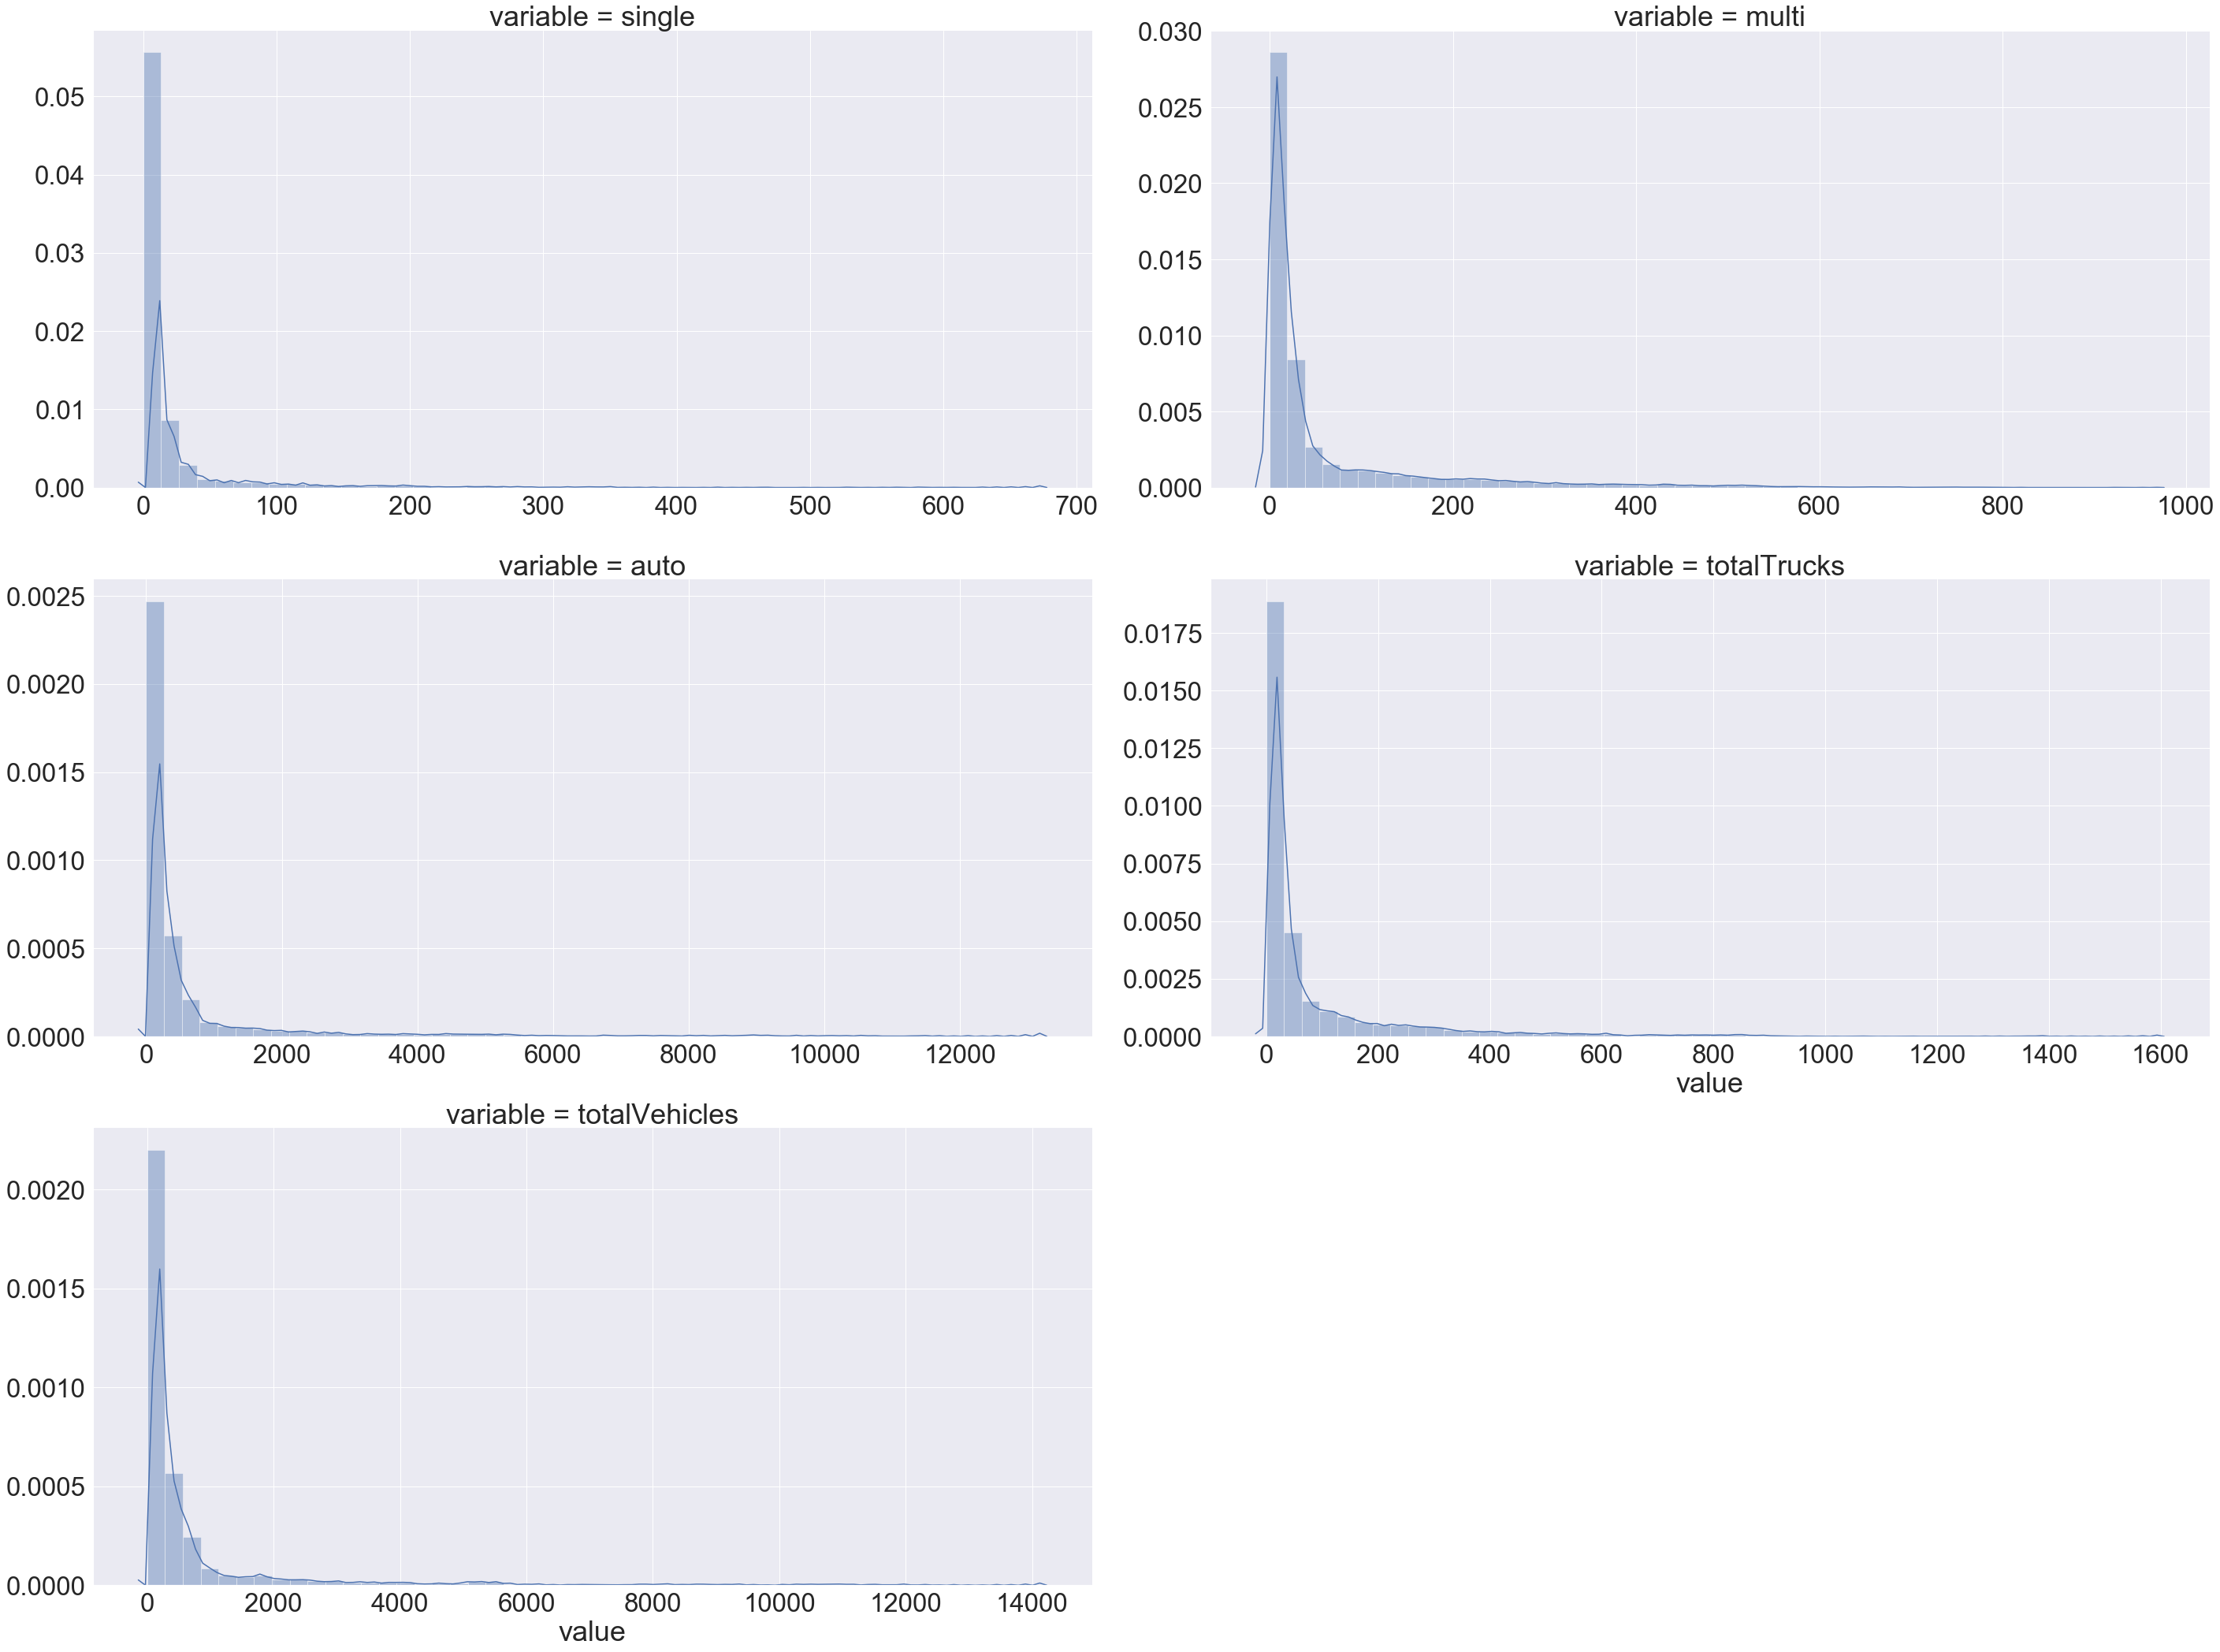

In [49]:
sns.set(font_scale = 3)
vehicles = data[['single','multi','auto','totalTrucks','totalVehicles']].melt()
g = sns.FacetGrid(vehicles, col="variable", col_wrap= 2, sharey=False, sharex=False, height=10, aspect=2)
g = g.map(sns.distplot, "value", kde=True)
plt.savefig('histogram_normal_scale.png')

In [20]:
data1 = data.copy()

In [18]:
data1 = np.log(data1[['single','multi','auto','totalTrucks','totalVehicles']] + 1)

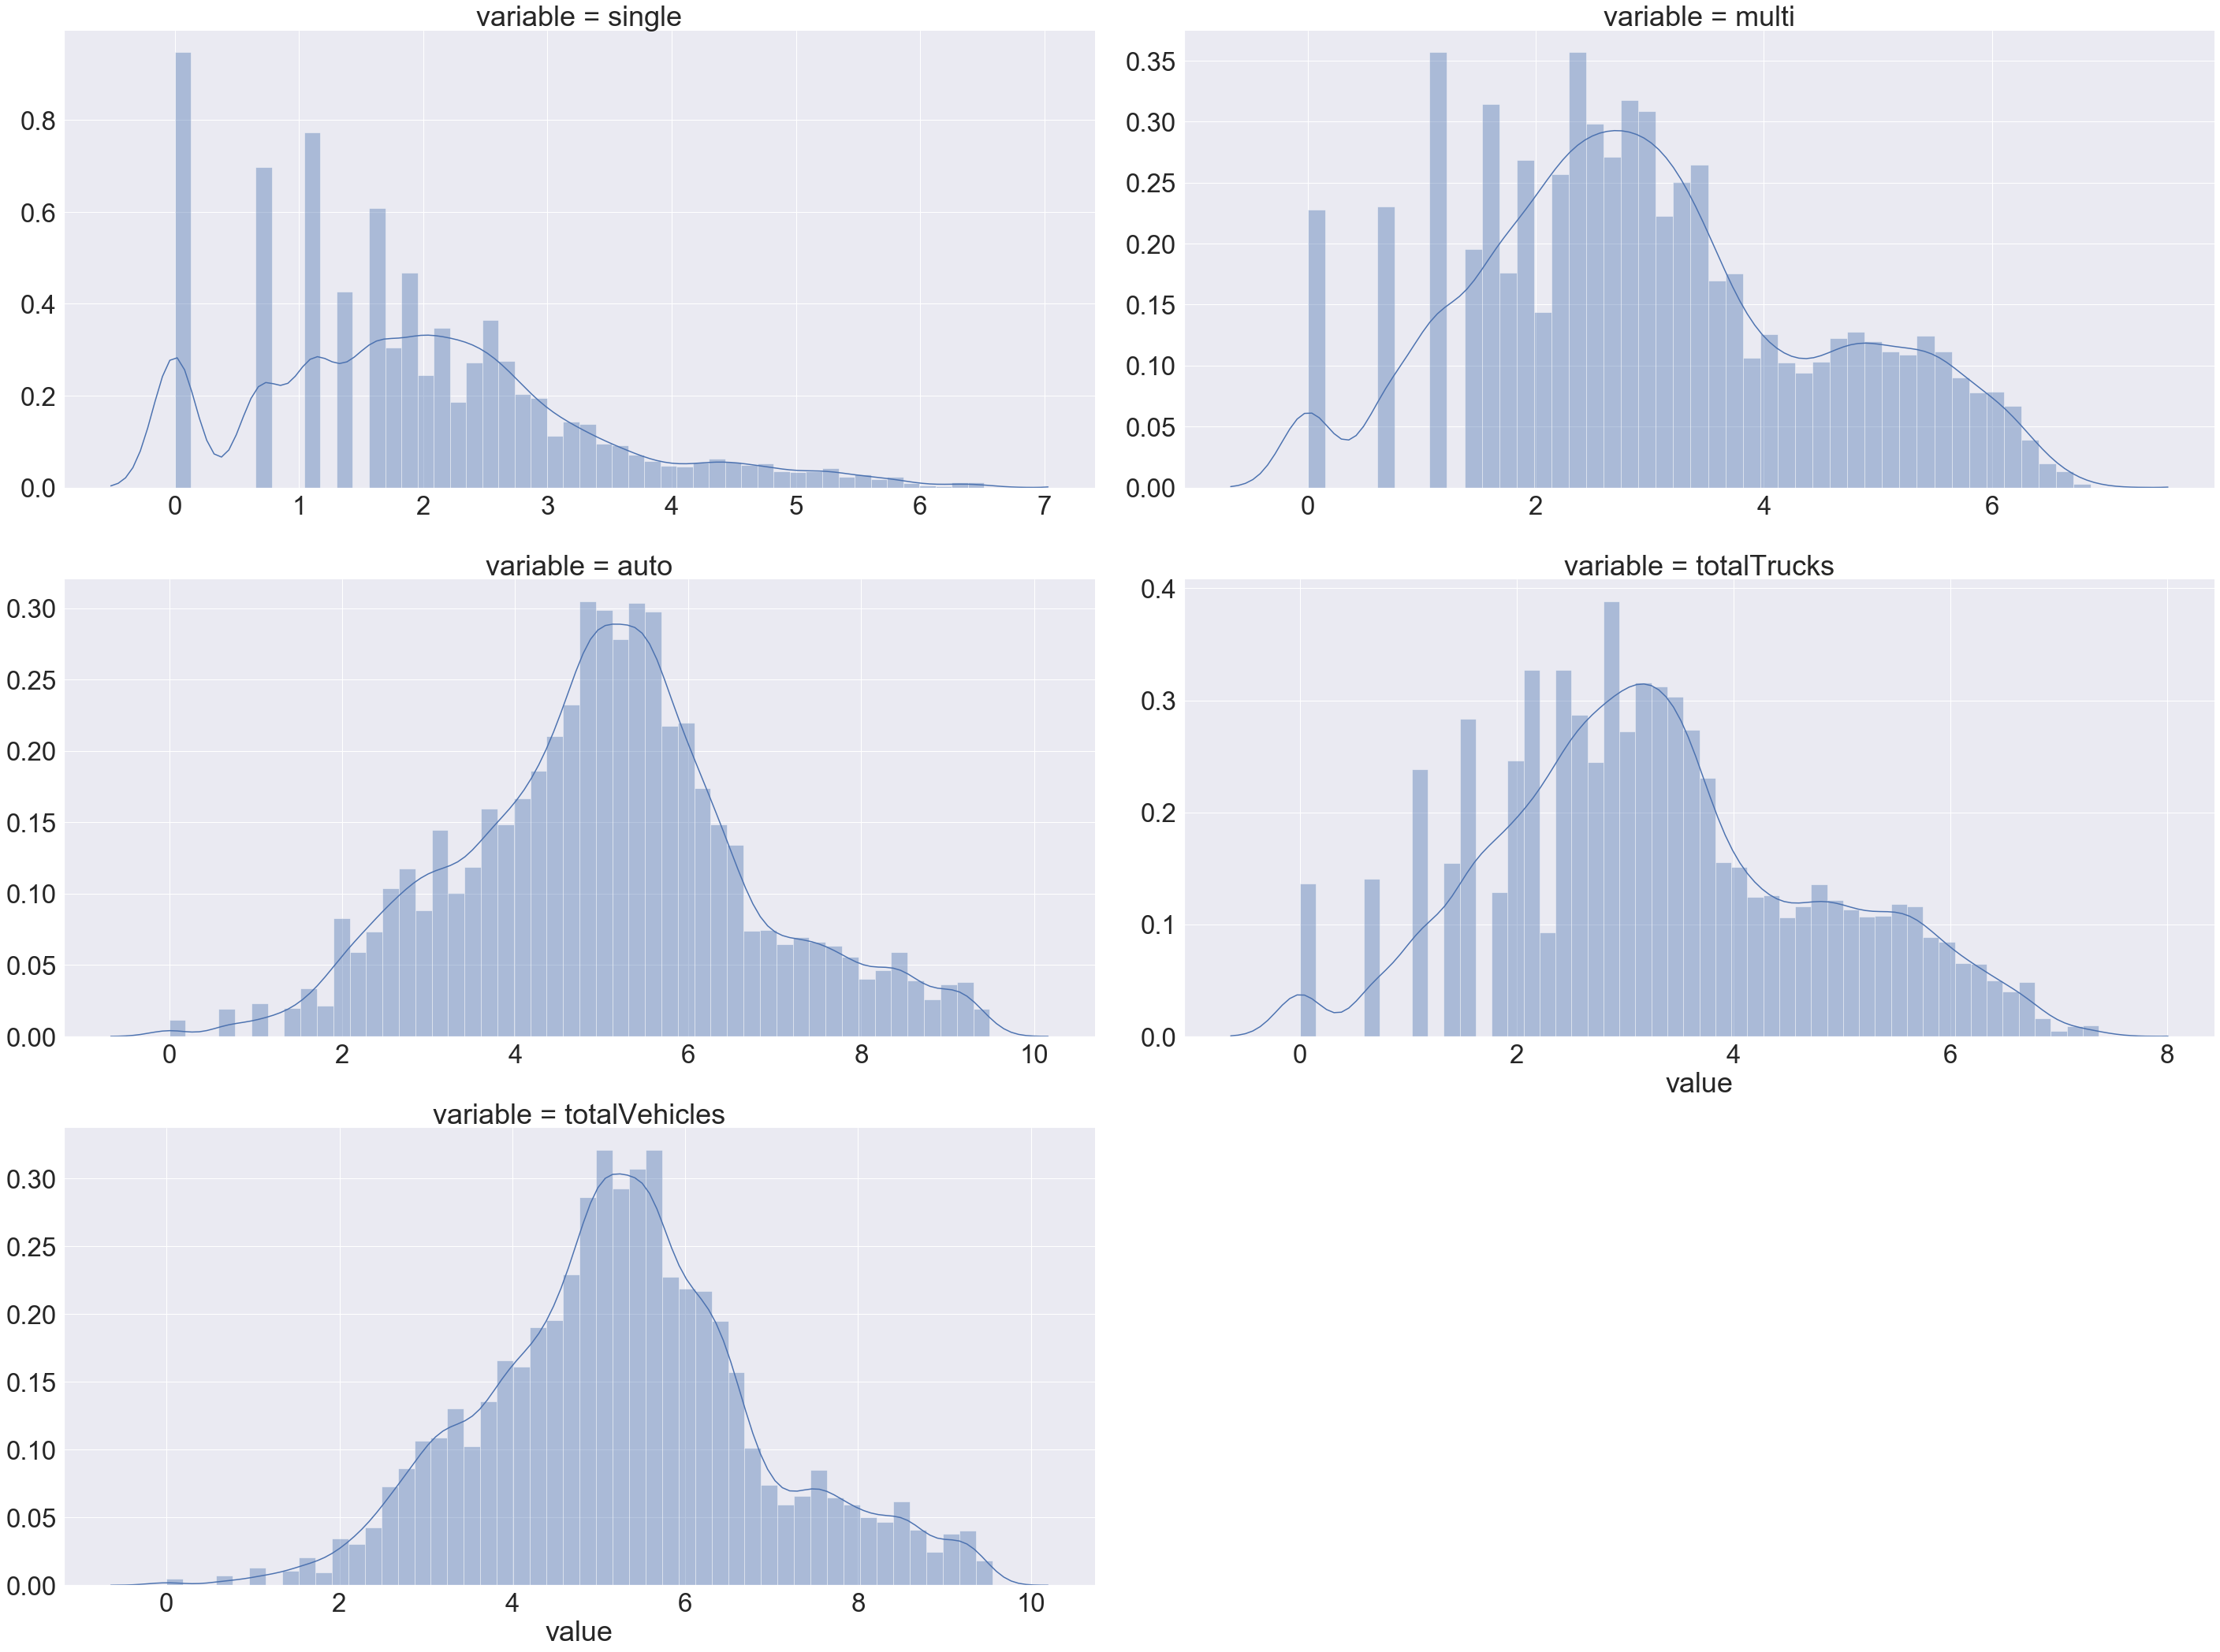

In [19]:
sns.set(font_scale = 3)
tips = data1[['single','multi','auto','totalTrucks','totalVehicles']].melt()
g = sns.FacetGrid(tips, col="variable", col_wrap= 2, sharey=False, sharex=False, height=10, aspect=2)
g = g.map(sns.distplot, "value", kde=True)
plt.savefig('histogram_logscale.png')

The distributions above show that the distribution of `totalVehicles` parallels the distribution of `auto` more than it does that of any of the other vehicle types, even though both are skewed. This basically confirms that the `totalVehicles` composition is made up more of `auto` than of any of the other vehicle types. The `totalTrucks` histogram also shares more similarity with `multi` than it does `single`. This emphasizes the point that there are more `multi` trucks in the dataset, and possibly in Ontario, than there are `single` trucks. 

However, the difference between all of them does seem significant. We could perhaps confirm this with a statistical test. We could employ the Krukal-Wallis test for completely randomized design since the individual group is not normal.

In [286]:
from scipy.stats import mstats
from scipy.stats import kruskalwallis


single = data['single'].values
multi = data['multi'].values
auto = data['auto'].values
totalTrucks = data['totalTrucks'].values
totalVehicles = data['totalVehicles'].values

print("Kruskal Wallis H-test test:")

H, pval = mstats.kruskalwallis(single, multi, auto, totalTrucks, totalVehicles)

print("H-statistic:", H)
print("P-Value:", pval)

H2, pval2 = ranksums(multi, totalTrucks)
print(H2, pval2)

Kruskal Wallis H-test test:
H-statistic: 36518.624468445065
P-Value: 0.0
-19.16783084319455 6.871481626017486e-82


In [819]:
def upper_fence(ser):
    return (np.quantile(ser, .75) + 
            1.5 * np.subtract(*np.quantile(ser, [.75,.25])))

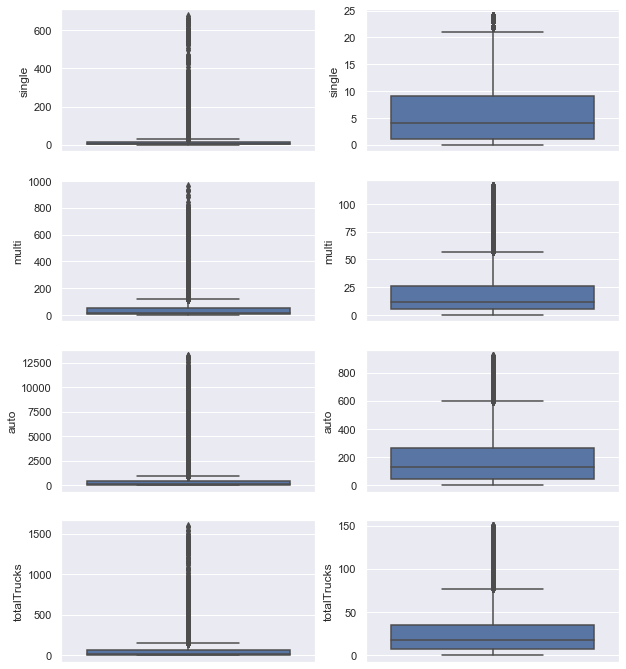

In [835]:
fig, ax = plt.subplots(4,2,figsize=(10,12))
i=0
for item in ['single', 'multi', 'auto', 'totalTrucks']:
    sns.boxplot(y=data[item], ax=ax[i,0])
    sns.boxplot(y=data[item][data[item]<=upper_fence(data[item])-5], ax=ax[i,1])
    i += 1

The boxplots confirms the presence of a lot of seeming outliers in the data set. However, since these are valid entries in the data set, we will not be discarding the outliers. The property of this kind of data seems to suggest that outlier will or should be present, since on certain days and in many more locations there will be less traffic than there are in other fewer congested areas where traffic will be heavy.

### Examining Stations

In [836]:
data.stationID.nunique()

104

The number of unique stations in the data set is only 104. Some of these span several `highway` data, while others are restricted to only one `highway` data. We will be taking a look at some of the more important stations closely.

First, we examine which stations recorded the biggest traffic?

#### Which station has the biggest traffic?

In [841]:
data.groupby('stationID').mean().sort_values(by=['totalVehicles','auto'], ascending=False)[:10]

,dayWeekNo,hour,single,multi,auto,totalTrucks,totalVehicles
stationID,,,,,,,
ON0115,4.0,11.5,221.285714,388.761905,7468.672619,610.136905,8078.821429
ON0116,4.0,11.5,244.267857,385.220238,7096.559524,629.416667,7725.994048
ON0140,4.0,11.5,133.690476,266.559524,5842.779762,400.261905,6243.023810
ON0139,4.0,11.5,131.565476,302.934524,5758.154762,434.458333,6192.613095
ON0027,4.0,11.5,100.744048,216.791667,3549.880952,317.547619,3867.178571
ON0026,4.0,11.5,111.428571,216.815476,3497.904762,328.250000,3826.130952
ON0033,4.0,11.5,84.904762,334.654762,2327.101190,419.565476,2746.678571
ON0032,4.0,11.5,84.886905,343.119048,2254.565476,428.041667,2682.630952
ON0034,4.0,11.5,90.434524,240.279762,2220.541667,330.720238,2551.267857


Stations `ON0115`, `ON0116` and `ON0140` recorded the biggest traffic around this period in the Ontario province. These counts may not provide the best insight into how significant the traffic recorded at these stations are, so it might be proper to examine the percentages.

In [25]:
stationsTraffic = data.groupby('stationID').mean().sort_values(by=['totalVehicles','auto'], ascending=False)
stationsTraffic['trafficPercentage'] = stationsTraffic['totalVehicles'] * 100 / stationsTraffic['totalVehicles'].sum()
stationsTraffic[:10]

,dayWeekNo,hour,single,multi,auto,totalTrucks,totalVehicles,trafficPercentage
stationID,,,,,,,,
ON0115,4.0,11.5,221.285714,388.761905,7468.672619,610.136905,8078.821429,10.688966
ON0116,4.0,11.5,244.267857,385.220238,7096.559524,629.416667,7725.994048,10.222145
ON0140,4.0,11.5,133.690476,266.559524,5842.779762,400.261905,6243.023810,8.260050
ON0139,4.0,11.5,131.565476,302.934524,5758.154762,434.458333,6192.613095,8.193352
ON0027,4.0,11.5,100.744048,216.791667,3549.880952,317.547619,3867.178571,5.116605
ON0026,4.0,11.5,111.428571,216.815476,3497.904762,328.250000,3826.130952,5.062296
ON0033,4.0,11.5,84.904762,334.654762,2327.101190,419.565476,2746.678571,3.634089
ON0032,4.0,11.5,84.886905,343.119048,2254.565476,428.041667,2682.630952,3.549348
ON0034,4.0,11.5,90.434524,240.279762,2220.541667,330.720238,2551.267857,3.375544


The percentages show that the three stations `ON0115`, `ON0116` and `ON0140` contribute all together close to 30% of the traffic experienced in all of Ontario. That's pretty significant. We will see later that these three stations are located on just one highway!

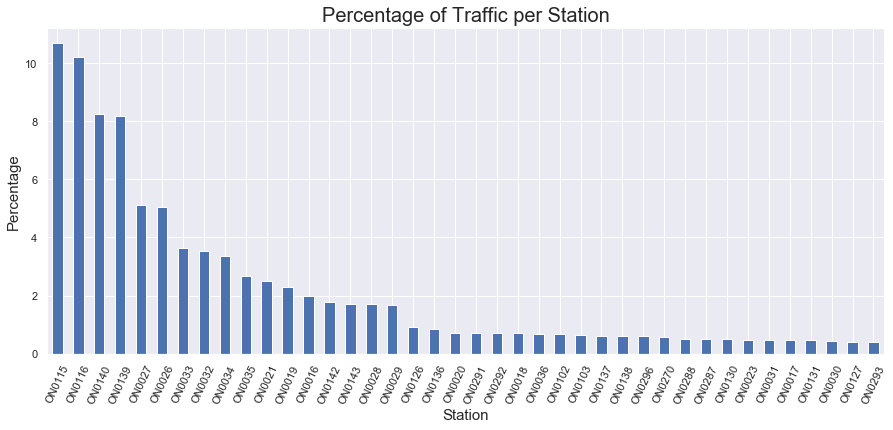

In [29]:
sns.set(font_scale = 1)
ax = stationsTraffic[:40]['trafficPercentage'].plot(kind='bar', figsize=(15,6))
ax.set_xticklabels(stationsTraffic[:40].index,rotation=65)
ax.set_title('Percentage of Traffic per Station', fontsize=20)
ax.set_ylabel('Percentage', fontsize=15)
ax.set_xlabel('Station', fontsize=15)
plt.savefig('Percentage_Traffic_per_Station.png')
plt.show()

The contributions from the first three stations are indeed rather significant as can be seen from the bar chart above.

Examining just the first few stations, we can establish that `auto` contributes the most traffic of all the kinds of vehicles. There are clearly more passenger vehicles in Ontario than there are trucks or other kinds of vehicles. `totalTrucks` represent the sum of `auto` and `multi`.

#### How does the vehicle traffic per station look?

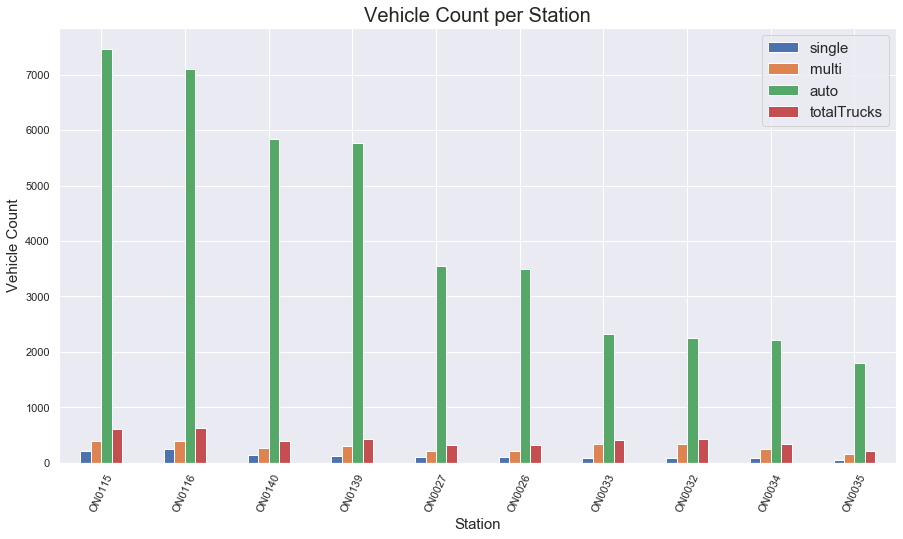

In [30]:
ax = stationsTraffic[['single', 
                      'multi', 
                      'auto', 
                      'totalTrucks']][:10].plot(kind='bar', figsize=(15,8))
ax.set_xticklabels(stationsTraffic[:10].index,rotation=65)
ax.set_title('Vehicle Count per Station', fontsize=20)
ax.set_ylabel('Vehicle Count', fontsize=15)
ax.set_xlabel('Station', fontsize=15)
ax.legend(fontsize=15)
plt.savefig('Vehicle_Count_per_Station.png')
plt.show()

We could also examine the correlation between each station. This will be the cross correlation between the respective time series data for each of the stations. Since there are 104 individual stations, we obtain a 104 x 104 correlation matrix which provides information on which station is correlated with which. We could use this to examine which stations share similar traffic patterns. Such traffic patterns could be correspondingly huge or small, but are unlikely to differ.

#### What is the correlation between traffic stations?

In [105]:
xcorr_values = pd.DataFrame()
for i in data.stationID.unique():
    for j in data.stationID.unique():
        xcorr_values.loc[i,j] = np.corrcoef(data['totalVehicles'][data['stationID'] == i],
             data['totalVehicles'][data['stationID'] == j]
            )[0,1]

In [880]:
xcorr_values.iloc[:10,:10]

,ON0016,ON0017,ON0018,ON0019,ON0020,ON0021,ON0023,ON0026,ON0027,ON0028
ON0016,1.000000,0.835759,0.828029,0.944157,0.823564,0.653928,0.773548,0.919496,0.830447,0.896659
ON0017,0.835759,1.000000,0.902044,0.785092,0.894211,0.686218,0.827678,0.785025,0.823906,0.841795
ON0018,0.828029,0.902044,1.000000,0.769971,0.963598,0.829272,0.929982,0.768847,0.840782,0.919299
ON0019,0.944157,0.785092,0.769971,1.000000,0.760991,0.676856,0.715410,0.955240,0.866054,0.891486
ON0020,0.823564,0.894211,0.963598,0.760991,1.000000,0.827941,0.852314,0.749793,0.803354,0.920054
ON0021,0.653928,0.686218,0.829272,0.676856,0.827941,1.000000,0.738702,0.716256,0.762247,0.860007
ON0023,0.773548,0.827678,0.929982,0.715410,0.852314,0.738702,1.000000,0.743007,0.827809,0.843518
ON0026,0.919496,0.785025,0.768847,0.955240,0.749793,0.716256,0.743007,1.000000,0.921943,0.899200
ON0027,0.830447,0.823906,0.840782,0.866054,0.803354,0.762247,0.827809,0.921943,1.000000,0.896194
ON0028,0.896659,0.841795,0.919299,0.891486,0.920054,0.860007,0.843518,0.899200,0.896194,1.000000


A slice of the matrix shows that most of the time series data correlate well with others. It appears traffic rises pretty much at the same rate all over the province and then settles back. The time plot below seems to confirm this for, at least, the first few stations.

In [683]:
xcorr_values.loc['ON0115'].sort_values(ascending=False)[:10]

ON0115    1.000000
ON0026    0.971024
ON0027    0.956176
ON0116    0.955947
ON0032    0.927297
ON0295    0.919560
ON0266    0.917262
ON0131    0.916901
ON0019    0.912492
ON0139    0.912113
Name: ON0115, dtype: float64

From the cross correlation matrix obtained, we can examine some of the other stations which correlate greatly with station `ON0015`. Ranking these values in descending order shows that `ON0026` and `ON0027` are some of the other stations whose traffic correlated rather highly with traffic at `ON0115`. We will examine the highways at these stations in later cells.

#### Is there any insight to be drawn from the traffic time series?

Now, we examine the pattern of traffic at different stations. The signature shows a big rise in `auto` traffic from the beginning of the day. This traffic peaks at about noon before settling back to near zero towards midnight. This pattern repeats every day of the week with some little differences. Some stations experience bigger traffic than others. Other stations show expectedly bigger peak on the first day of the week when people rush to work, and lesser traffic peaks for the rest of the week. `totalTrucks` traffic is mild at some stations and huge at others.

With a uniform `yaxis`, we can visually compare the scale of traffic at these different locations, and can immediately establish, for example, that traffic on `ON0021` is bigger than that on `ON0017`.

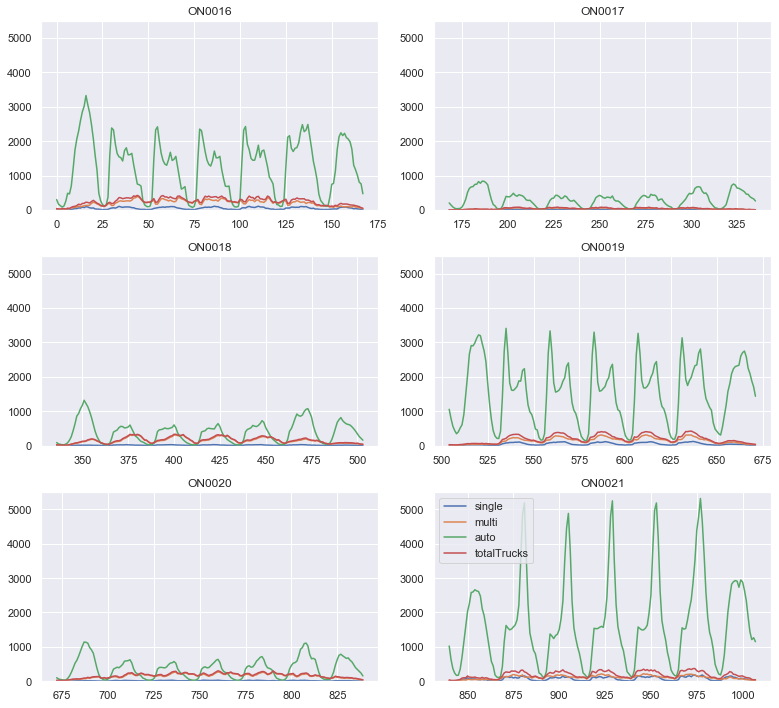

In [52]:
sns.set(font_scale = 1)
fig, ax = plt.subplots(3,2, figsize=(11,10))
# plt.figure(figsize=(10,8))
for i, station in enumerate(data['stationID'].unique()[:6]):
    (ax[i//2,i%2]
     .plot(data[['single', 'multi', 'auto', 'totalTrucks']][data['stationID'] == station]))
    (ax[i//2,i%2].
    set_title(station))
    (ax[i//2,i%2].
    set_ylim(0,5500))

ax[i//2,i%2].legend(['single', 'multi', 'auto', 'totalTrucks'])
plt.tight_layout()

This view above offers some insight into the way traffic is distributed across the highways. We see that station `ON0021` houses a particularly curious peak during afternoon hours each working day.

The plot is reproduced below to get a closer view.

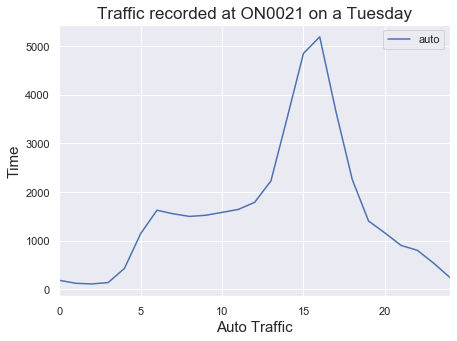

In [93]:
data[data.stationID == 'ON0021'][25:50].reset_index()[['auto']].plot(figsize=(7,5))
plt.title('Traffic recorded at ON0021 on a Tuesday', fontsize=17)
plt.xlabel('Auto Traffic', fontsize=15)
plt.ylabel('Time', fontsize=15)
None

This station is located on `Hwy 400` between King Rd & Kettleby Rd north of Vaughan. The map below shows us the location of this station. This spike looks to be the daily homeward traffic from downtown Toronto in the nothern direction as seem in the information displayed below. A driver who cares to avoid this traffic would perhaps seek an alternative route as this traffic seems a daily occurence.

In [96]:
print('ON0021 is located on {} and carries traffic in the {} direction'.format(
    data[data.stationID == 'ON0021'].locationDescription.unique(), data[data.stationID == 'ON0021'].direction.unique()))

ON0021 is located on ['On Highway 400, between King Rd (York Rd 11- Exit 43) & Kettleby Rd (Exit 52), about 2 km north of King Rd ( Km Marker 45)'] and carries traffic in the ['North'] direction


In [594]:
!pip install folium

In [152]:
# Run cell to see map of station location!

import folium
from folium.plugins import MarkerCluster

King_to_Kettleby = pd.read_csv('''./mygeodata/On_Highway_400_between_King_Rd_York_Rd_11_Exit_43_Kettleby_Rd_Exit_52_about_2_km_north_of_King_Rd_Km_Marker_45.csv''')
#Add markers to the map
King = [King_to_Kettleby.loc[0, 'Y'], King_to_Kettleby.loc[0,'X']]
Kettleby = [King_to_Kettleby.loc[1, 'Y'], King_to_Kettleby.loc[1,'X']]

#Create the map
my_map = folium.Map(location = King, zoom_start = 11)
folium.Marker(King, popup = 'King Rd').add_to(my_map)
folium.Marker(Kettleby, popup = 'Kettleby Rd').add_to(my_map)

#Display the map
my_map.save('King_to_Kettleby.html')
my_map

### Examining Highways

In [882]:
data[data.stationID == 'ON0115'].highway[:4]

5376    Hwy 401
5377    Hwy 401
5378    Hwy 401
5379    Hwy 401
Name: highway, dtype: object

We confirmed earlier that the biggest traffic was registered by station `ON0115`. It appears this station is located on `Hwy 401`. We will now look closely at the respective highways in the data set.

#### What is the traffic distribution for the highway with the biggest traffic?

First, we visualize the nature of traffic in some of the stations which cover `Hwy 401`. By paying attention to the y-scale, we see that `ON0115`, `ON0116`, `ON0139`, and `ON0140` appear to carry rather heavy traffic compared to the others as shown in the plots below.

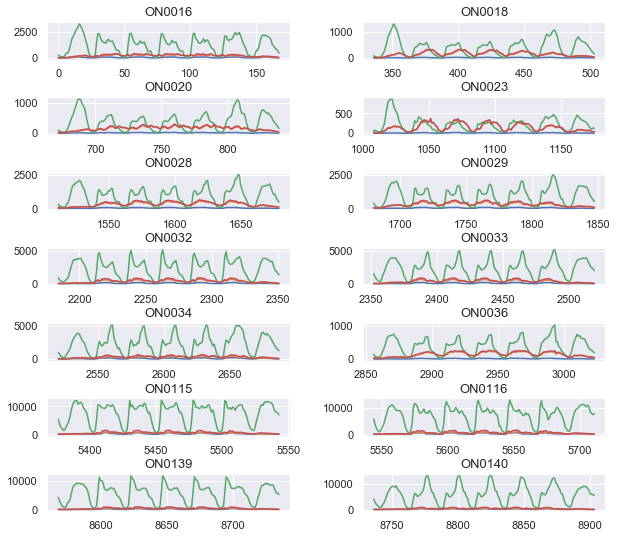

In [34]:
fig, ax = plt.subplots(7,2, figsize=(10,9), gridspec_kw={'wspace': 0.3, 'hspace': 1.0})
for i,j in enumerate(data[data['highway'] == 'Hwy 401']['stationID'].unique()):
    ax[i//2, i%2].plot(data[['single', 
                             'multi', 
                             'auto', 
                             'totalTrucks']][(data['highway'] == 'Hwy 401') & (data['stationID'] == j)], 
                       label=j)
    ax[i//2, i%2].set_title(j, fontsize=13)
plt.savefig('Traffic_per_Station_Hwy401.png')
None

This initial analysis confirms what we already know; that `Hwy 401` registers some of the biggest traffic in Ontario.
We could examine where `ON0115` is located on the map.

In [904]:
data[data['stationID'] == 'ON0115'].locationDescription.unique()

array(['On Highway 401, from Hwy 401 westbound collectors east of Keele St to MTO Parking Lot north of Hwy 401 on west side of Keele St'],
      dtype=object)

In [102]:
Keele_to_MTO = pd.read_csv('''./mygeodata/On_Highway_401_from_Hwy_401_eastbound_collectors_west_of_Keele_St_to_MTO_Parking_Lot_north_of_Hwy_401_on_west_side_of_Keele_St.csv''')
#Add markers to the map
Keele = [Keele_to_MTO.loc[0, 'Y'], Keele_to_MTO.loc[0,'X']]
MTO_Lot = [Keele_to_MTO.loc[1, 'Y'], Keele_to_MTO.loc[1,'X']]

#Create the map
my_map = folium.Map(location = Keele, zoom_start = 15)
folium.Marker(Keele, popup = 'Keele Street').add_to(my_map)
folium.Marker(MTO_Lot, popup = 'MTO Parking Lot').add_to(my_map)

#Display the map
my_map.save('Keele_to_MTO.html')
my_map

This is located westbound from east of Keele Street to the MTO Parking lot north of `Hwy 401`. This is only a few kilometers from downtown Toronto.

In [905]:
data[data['stationID'] == 'ON0116'].locationDescription.unique()

array(['On Highway 401, from Hwy 401 eastbound collectors west of Keele St to MTO Parking Lot north of Hwy 401 on west side of Keele St'],
      dtype=object)

Station `ON0116` monitors the eastbound traffic.

In [906]:
data[data['stationID'] == 'ON0139'].locationDescription.unique()

array(['On Highway 401, from Hwy 401 westbound collectors east of Kennedy Rd to Maintenance Yard north of Hwy 401 on west side of Kennedy Rd'],
      dtype=object)

In [103]:
Kennedy_to_Maint = pd.read_csv('''./mygeodata/On_Highway_401_from_Hwy_401_eastbound_collectors_west_of_Kennedy_Rd_to_Maintenance_Yard_north_of_Hwy_401_on_west_side_of_Kennedy_Rd.csv''')
#Add markers to the map
Kennedy = [Kennedy_to_Maint.loc[0, 'Y'], Kennedy_to_Maint.loc[0,'X']]
Maint_Yard = [Kennedy_to_Maint.loc[1, 'Y'], Kennedy_to_Maint.loc[1,'X']]

#Create the map
my_map = folium.Map(location = Kennedy, zoom_start = 12)
folium.Marker(Kennedy, popup = 'Kennedy Street').add_to(my_map)
folium.Marker(Maint_Yard, popup = 'Maintenance Yard').add_to(my_map)

#Display the map
my_map

Station `ON0139` is just off the airport around Mississauga. This is also one of the areas with rather heavy traffic in the province.

The subplots showed that station `ON0115` on `Hwy 401` records some of the biggest traffic. From the cross correlation matrix examined earlier, we observed some of the other stations correlate greatly with station `ON0015`. Ranking these values in descending order shows that `ON0026` and `ON0027` are some of the other stations whose traffic correlate rather highly with traffic at `ON0115`. This could mean they also register sizeable traffic. We could take a look.

In [106]:
xcorr_values.loc['ON0115'].sort_values(ascending=False)[:10]

ON0115    1.000000
ON0026    0.971024
ON0027    0.956176
ON0116    0.955947
ON0032    0.927297
ON0295    0.919560
ON0266    0.917262
ON0131    0.916901
ON0019    0.912492
ON0139    0.912113
Name: ON0115, dtype: float64

The `locationDescription` of `ON0026` shows that it is on Queen Elizabeth Drive.

In [689]:
data.locationDescription[data['stationID']=='ON0026'].unique()

array(['On QEW, between Third Line (Exit 113) & Dorval Dr (Exit 116) (Km Marker 112)'],
      dtype=object)

In [690]:
QEW_to_Dorval = pd.read_csv('./mygeodata/On_QEW_between_Dorval_Dr_Exit_116_Third_Line_Exit_113_Km_Marker_112.csv')
QEW_to_Dorval

,X,Y,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon
0,-79.700094,43.446556,Dorval Drive,NaN,NaN,NaN,NaN,NaN,-1,0,-1,NaN,NaN
1,-79.725401,43.423799,Third Line,NaN,NaN,NaN,NaN,NaN,-1,0,-1,NaN,NaN


In [109]:
QEW_to_Dorval = pd.read_csv('./mygeodata/On_QEW_between_Dorval_Dr_Exit_116_Third_Line_Exit_113_Km_Marker_112.csv')
QEW_to_Dorval


Dorval_Drive = [QEW_to_Dorval.loc[0, 'Y'], QEW_to_Dorval.loc[0,'X']]
Third_Line = [QEW_to_Dorval.loc[1, 'Y'], QEW_to_Dorval.loc[1,'X']]

#Add markers to the map


#Create the map
my_map = folium.Map(location = Dorval_Drive, zoom_start = 13)
folium.Marker(Dorval_Drive, popup = 'Dorval Drive').add_to(my_map)
folium.Marker(Third_Line, popup = 'Third Line').add_to(my_map)
#Display the map
my_map

This is very close to iFly Toronto and is the expressway that leads into Mississauga around Oakville. Little wonder it experiences a lot of traffic.

Just north of this expressway is another expressway leading into Missisauga and connecting to Trafalgar Road. It appears there is also a station here. We could also examine how big vehicular traffic here is.

In [694]:
data[data.locationDescription.str.contains('Trafalgar')].stationID.unique()

array(['ON0032', 'ON0033'], dtype=object)

There are two stations with numbers `ON0033` and `ON0032`. How big is the traffic here compared to the station south of it, and also compared to the station at `ON0115`?

In [701]:
(data.groupby('stationID')
 .mean()
 .loc[['ON0115','ON0032','ON0033', 'ON0026']]
 .iloc[:, 2:]).sort_values(by='totalVehicles', ascending=False)

,single,multi,auto,totalTrucks,totalVehicles
stationID,,,,,
ON0115,221.285714,388.761905,7468.672619,610.136905,8078.821429
ON0026,111.428571,216.815476,3497.904762,328.250000,3826.130952
ON0033,84.904762,334.654762,2327.101190,419.565476,2746.678571
ON0032,84.886905,343.119048,2254.565476,428.041667,2682.630952


Traffic north of `ON0026` appears relatively milder. This is probably because there is a toll and as such is avoided by most drivers. The traffic is therefore much less. Station `ON0115` on `Hwy 401` remains heavy with traffic.

#### Which highways have the biggest traffic?

Now, we sort traffic by `highway` and arrange the results in order of decreasing mean traffic count.
The highways with the biggest traffic in Ontario appear to be `Hwy 401`, `QEW`, `King Edward Ave`, and `Hwy 400`. 
`Hwy 401` runs the length of the south of Ontario extending from its end near Detroit in the United States to the east as far as Ottawa. It apparently is also very busy because it carries traffic westwards and eastwards into Ontario's major city, Toronto.

In [309]:
(pd.pivot_table(data=data, index='highway', values=['multi', 'auto', 'single', 
                                                    'totalTrucks', 'totalVehicles'], aggfunc='mean')
.sort_values(by='auto', ascending=False)
.head(10))

,auto,multi,single,totalTrucks,totalVehicles
highway,,,,,
Hwy 401,2675.036990,259.219813,83.672619,342.901361,3017.951531
QEW,1838.720238,144.555556,55.169643,199.663690,2038.305556
King Edward Ave,1266.598214,38.711310,23.089286,61.800595,1328.363095
Hwy 400,743.210317,54.644841,31.581349,86.248016,829.472222
Fleet St,479.261905,10.699405,6.889881,17.589286,496.877976
Hwy 416,439.693452,21.202381,7.928571,29.145833,468.895833
Hwy 26,437.428571,5.136905,5.232143,10.410714,447.851190
Hwy 10,420.630952,15.982143,7.339286,23.410714,444.035714
Hwy 6,361.696429,18.833333,7.926587,26.783730,388.496032


We could also examine the percentage of vehicular traffic each `highway` experiences?

In [991]:
highwayTraffic = (pd.pivot_table(data=data, index='highway', values=['multi', 'auto', 'single', 
                                                    'totalTrucks', 'totalVehicles'], aggfunc='mean')
.sort_values(by='auto', ascending=False))
highwayTraffic['trafficPercentage'] = highwayTraffic['totalVehicles'] * 100 / highwayTraffic['totalVehicles'].sum()
highwayTraffic[:10]

,auto,multi,single,totalTrucks,totalVehicles,trafficPercentage
highway,,,,,,
Hwy 401,2675.036990,259.219813,83.672619,342.901361,3017.951531,22.024959
QEW,1838.720238,144.555556,55.169643,199.663690,2038.305556,14.875519
King Edward Ave,1266.598214,38.711310,23.089286,61.800595,1328.363095,9.694371
Hwy 400,743.210317,54.644841,31.581349,86.248016,829.472222,6.053474
Fleet St,479.261905,10.699405,6.889881,17.589286,496.877976,3.626207
Hwy 416,439.693452,21.202381,7.928571,29.145833,468.895833,3.421994
Hwy 26,437.428571,5.136905,5.232143,10.410714,447.851190,3.268410
Hwy 10,420.630952,15.982143,7.339286,23.410714,444.035714,3.240565
Hwy 6,361.696429,18.833333,7.926587,26.783730,388.496032,2.835237


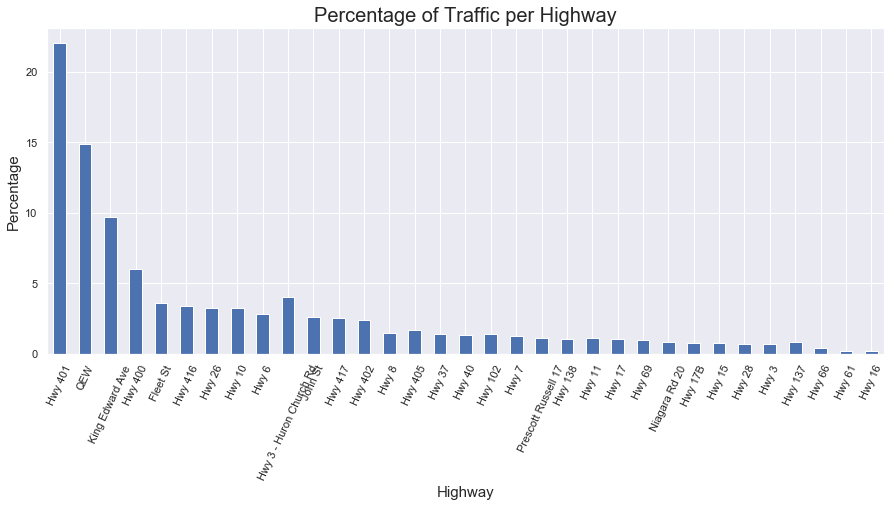

In [992]:
ax = highwayTraffic[:40]['trafficPercentage'].plot(kind='bar', figsize=(15,6))
ax.set_xticklabels(highwayTraffic[:40].index,rotation=65)
ax.set_title('Percentage of Traffic per Highway', fontsize=20)
ax.set_ylabel('Percentage', fontsize=15)
ax.set_xlabel('Highway', fontsize=15)
plt.show()

Here, we are able to establish that only three highways in the province, `Hwy 401`, `QEW` and `King Edward Ave` account for more than 50% of vehicular traffic in the province!

#### Is there any insight to be drawn from the traffic data on the biggest highway?

For `Hwy 401`, we could look at the time series traffic data for each day of the week. This could help shed light on exactly how traffic changes each day of the week.

In [517]:
# X1 = data[(data["stationID"]=="ON0016") & (data["dayWeekNo"]==1)]
# plt.plot(X1['hour'],X1['auto'],label='ON0016')
# X2 = data[(data["stationID"]=="ON0018") & (data["dayWeekNo"]==1)]
# plt.plot(X2['hour'],X1['auto'],label='ON0018')

def plot_hourly_chart(stations,dayWeekNo):
#     fig,ax=plt.subplots(figsize=(9,5))


    for station in stations:
        X = data[(data["stationID"]==station) & (data["dayWeekNo"]==dayWeekNo)]
        ax.plot(X["hour"], X["auto"], label=station)
    plt.legend(loc='upper left')
    
None

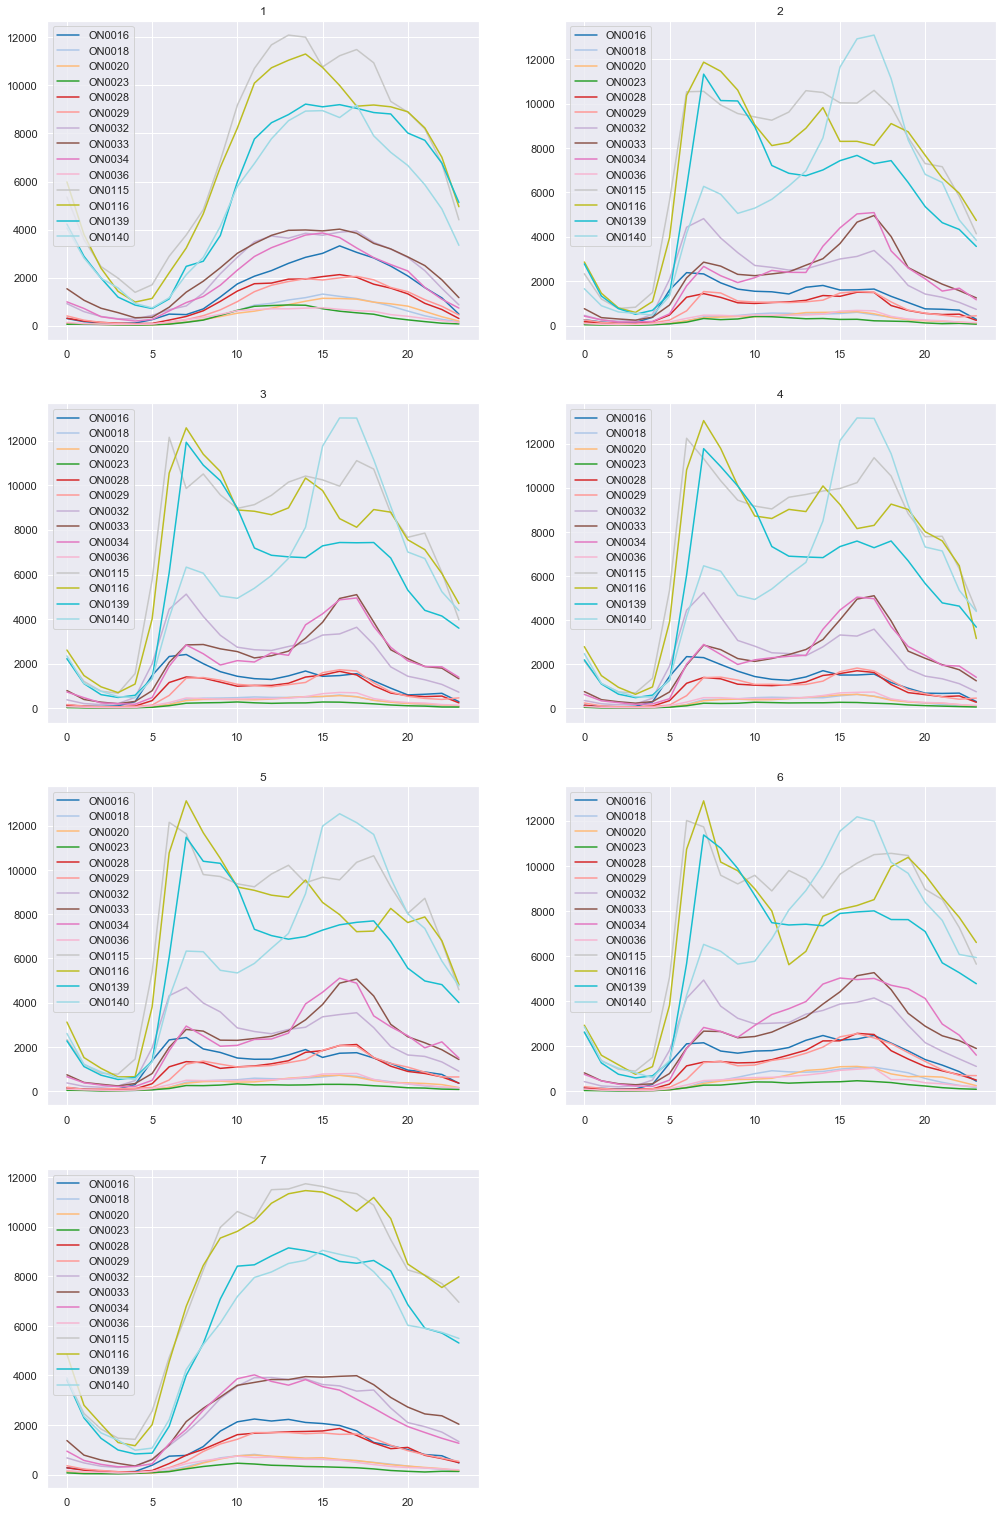

In [928]:
import numpy as np
from matplotlib.pyplot import cm

# viridisBig = cm.get_cmap('viridis', 512)
stations = data[data['highway']=='Hwy 401'].stationID.unique()
dayWeekNos = range(1,8)
i=1
plt.figure(figsize=[17,27])
# fig = plt.figure()

for dayWeekNo in dayWeekNos:
    fig=plt.subplot(4,2,i)
    color=iter(cm.tab20(np.linspace(0,1,len(stations))))
    for station in stations:
        c=next(color)
        X = data[(data["stationID"]==station) & (data["dayWeekNo"]==dayWeekNo)]
        fig.plot(X["hour"], X["auto"], label=station, c=c)
        fig.set_title(dayWeekNo)
        plt.legend(loc='upper left')
#     plot_hourly_chart(stations,dayWeekNo)
    i+=1

Traffic appears to begin around 5am in the morning and increases gently during the day, peaking on major highways around noon. Vehicle density does not seem to reduce until towards evening around 6pm, so that by midnight it goes down significantly. On the last day of the week, it appears many more cars stay on the road even towards evening (parties? night outs?), as it appears vehicle density does not reduce significantly on this day unlike on others. The consistency in these plots suggest that the probability of getting caught in traffic trends higher as the morning arrives. To beat traffic, one would have to be on the road as early as 5-6am. Leaving any sooner or later does not appear to help.

Quite remarkably, we see a gentle slope for both the first and last day of the week, and steeper slopes for all other days. Could this suggest some lethargy preventing people from hurrying to work on a Monday and more people relaxing at home on the weekend, compared to other busy days of the week? It would certainly be interesting if data from the other highways suggest the same information.

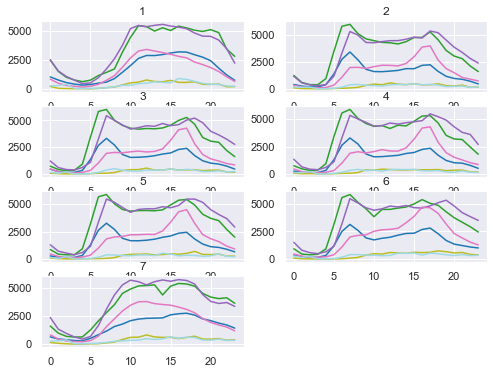

In [927]:
import numpy as np
from matplotlib.pyplot import cm

# viridisBig = cm.get_cmap('viridis', 512)
stations = data[data['highway']=='QEW'].stationID.unique()
dayWeekNos = range(1,8)
i=1
plt.figure(figsize=(8,6))
# fig = plt.figure()

for dayWeekNo in dayWeekNos:
    fig=plt.subplot(4,2,i)
    color=iter(cm.tab20(np.linspace(0,1,len(stations))))
    for station in stations:
        c=next(color)
        X = data[(data["stationID"]==station) & (data["dayWeekNo"]==dayWeekNo)]
        fig.plot(X["hour"], X["auto"], label=station, c=c)
        fig.set_title(dayWeekNo)
#         plt.legend(loc='upper left')
#     plot_hourly_chart(stations,dayWeekNo)
    i+=1

It appears data from `QEW` also suggest the same?

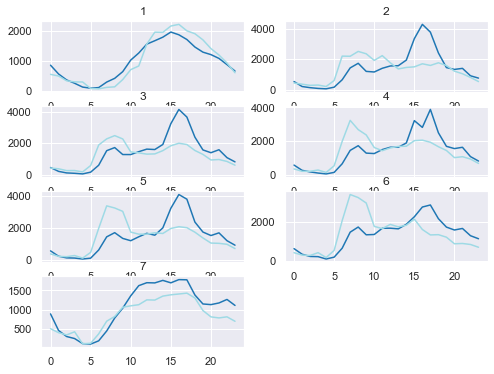

In [929]:
import numpy as np
from matplotlib.pyplot import cm

# viridisBig = cm.get_cmap('viridis', 512)
stations = data[data['highway']=='King Edward Ave'].stationID.unique()
dayWeekNos = range(1,8)
i=1
plt.figure(figsize=(8,6))
# fig = plt.figure()

for dayWeekNo in dayWeekNos:
    fig=plt.subplot(4,2,i)
    color=iter(cm.tab20(np.linspace(0,1,len(stations))))
    for station in stations:
        c=next(color)
        X = data[(data["stationID"]==station) & (data["dayWeekNo"]==dayWeekNo)]
        fig.plot(X["hour"], X["auto"], label=station, c=c)
        fig.set_title(dayWeekNo)
#         plt.legend(loc='upper left')
#     plot_hourly_chart(stations,dayWeekNo)
    i+=1

Similarly, data from `King Edward Ave` seems to suggest the same. There clearly is a steep slope on days 2 to 6, and gentler slopes on days 1 and 7.

#### Which vehicles contribute the biggest traffic per highway?

Now, we can examine just how significant the traffic is for each `highway` in the data set. We already know that `Hwy 401` contributes the biggest traffic in the province. But how about the other highways?

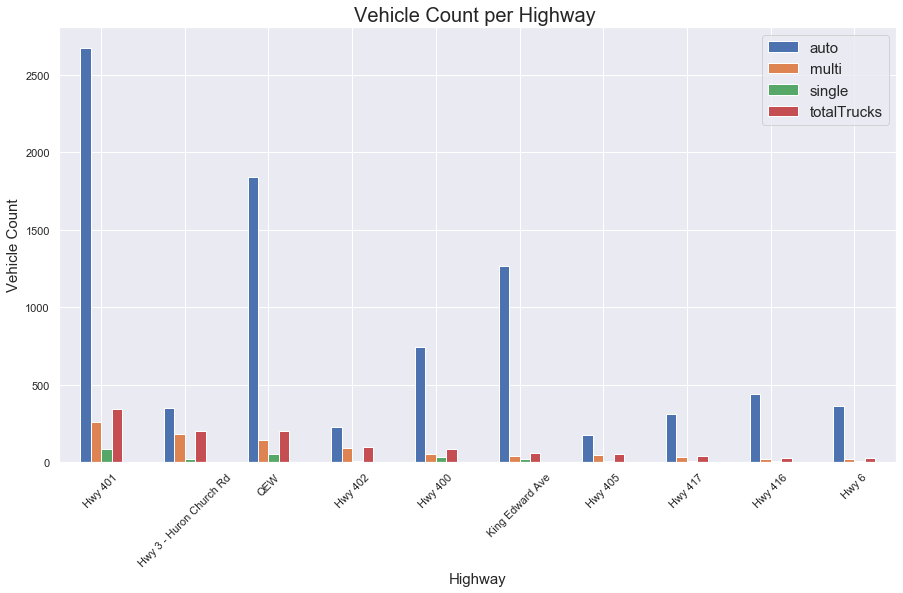

In [917]:
ax = (pd.pivot_table(data=data, index='highway', values=['multi', 'auto', 'single', 
                                                    'totalTrucks'], aggfunc='mean')
.sort_values(by='totalTrucks', ascending=False)
.head(10)).plot(kind='bar', figsize=(15,8))
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=45)
ax.set_title('Vehicle Count per Highway ', fontsize=20)
ax.set_ylabel('Vehicle Count', fontsize=15)
ax.set_xlabel('Highway', fontsize=15)
ax.legend(fontsize=15)
plt.show()

Again, `auto` make up the highest vehicle count for every highway. Apparently, it would seem there are many more small cars in the Ontario province than there are trucks. However, are there areas in the province where trucks may dominate?

We examine again the distribution of vehicular traffic for each highway and sort by `totalVehicles` and `totalTrucks`. This time we express `totalTrucks` as a percentage of `totalVehicles`.

In [932]:
highwayTraffic = (data
                  .groupby(by='highway')
                  .mean()
                  .sort_values(by=['totalVehicles', 'totalTrucks'], 
                               ascending=False)[['single','multi','auto','totalTrucks','totalVehicles']])
highwayTraffic['truckPercentage'] = highwayTraffic['totalTrucks'] * 100 / highwayTraffic['totalVehicles']
highwayTraffic.sort_values(by='truckPercentage', ascending=False)[:10]

,single,multi,auto,totalTrucks,totalVehicles,truckPercentage
highway,,,,,,
Hwy 3 - Huron Church Rd,19.988095,179.699405,348.907738,199.687500,548.568452,36.401565
Hwy 402,9.669643,91.293155,224.244048,100.967262,325.196429,31.048084
Hwy 405,10.407738,43.321429,178.351190,53.711310,232.023810,23.149051
Hwy 137,0.985119,25.315476,90.875000,26.324405,117.208333,22.459499
Hwy 69,5.297619,20.985119,110.758929,26.303571,137.086310,19.187599
Hwy 16,1.377976,3.937500,23.657738,5.401786,29.098214,18.563977
Hwy 17,5.686111,17.944048,116.355952,23.634127,140.003571,16.881089
Hwy 61,2.568452,2.187500,26.967262,4.800595,31.794643,15.098755
Hwy 7,6.169048,15.351190,154.845238,21.514286,176.363095,12.198859


Some of the areas with the biggest truck traffic appear to be `Hwy 3 - Huron Church Rd`, `Hwy 402`, and `Hwy 405`. We see that even though `Hwy 401` and `QEW` may have the biggest traffic in Ontario province, they actually account for insignificant truck traffic.

These areas are located on the maps below.

In [937]:
data[data.highway == 'Hwy 3 - Huron Church Rd'].locationDescription.unique()

array(['On the Ambassador Bridge Plaza, before toll booths entering Michigan',
       'On the Ambassador Bridge Plaza, after Canada Customs entering Ontario'],
      dtype=object)

In [934]:
Amb_bridge_to_Toll = pd.read_csv('./mygeodata/On_Blue_Water_Bridge_Plaza_after_toll_booths_entering_Michigan.csv')
Amb_bridge_to_Toll

,X,Y,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon
0,-82.42353,42.998515,Blue Water Bridge,NaN,NaN,NaN,NaN,NaN,-1,0,-1,NaN,NaN


In [112]:
Amb_bridge_to_Toll = pd.read_csv('./mygeodata/On_Blue_Water_Bridge_Plaza_after_toll_booths_entering_Michigan.csv')


Blue_Water_Bridge = [Amb_bridge_to_Toll.loc[0, 'Y'], Amb_bridge_to_Toll.loc[0,'X']]

#Add markers to the map


#Create the map
my_map = folium.Map(location = Blue_Water_Bridge, zoom_start = 17)
folium.Marker(Blue_Water_Bridge, popup = 'Blue Water Bridge').add_to(my_map)
#Display the map
my_map

In [936]:
data[data.highway == 'Hwy 402'].locationDescription.unique()

array(['On Highway 402, between Town Line (Lambton Rd 26 - Exit 15) & Oil Heritage Rd (Lambton Rd 21 - Exit 25), about 4.8 km east of Lambton Rd 26 (Km Mar',
       'On Highway 402, between Oil Heritage Rd (Lambton Rd 21 - Exit 25) & Town Line (Lambton Rd 26 - Exit 15), about 4.8 km east of Lambton Rd 26 (Km Mar',
       'On Blue Water Bridge Plaza, after toll booths entering Michigan',
       'On Blue Water Bridge Plaza, after Canada Customs entering Ontario'],
      dtype=object)

In [125]:
Oil_Heritage_to_Town_Line = pd.read_csv('./mygeodata/On_Highway_402.csv')


Oil_Heritage = [Oil_Heritage_to_Town_Line.loc[0, 'Y'], Oil_Heritage_to_Town_Line.loc[0,'X']]
Town_Line = [Oil_Heritage_to_Town_Line.loc[1, 'Y'], Oil_Heritage_to_Town_Line.loc[1,'X']]

#Add markers to the map


#Create the map
my_map = folium.Map(location = Oil_Heritage, zoom_start = 12)
folium.Marker(Oil_Heritage, popup = 'Oil Heritage Road').add_to(my_map)
folium.Marker(Town_Line, popup = 'Town Line').add_to(my_map)
#Display the map
my_map

These highways with huge truck traffic are located close to border toll stations in Ontario. This would seem to suggest that more trucks than cars are to be found around the borders of Ontario than inside the province itself. Evidently, this supports the suspicion of significant commercial activity at the borders of the United States and Canada.

### Examining Directions

#### In what direction is the most significant traffic?

Next, we examine the directions in which most traffic is recorded in the province.

In [424]:
data.pivot_table(index="direction", columns=["dayWeekNo"], values=["totalVehicles"], aggfunc="mean")

totalVehicles                                                      \
dayWeekNo             1            2            3            4            5   
direction                                                                     
East         940.806034  1047.393678  1077.477011  1095.419540  1122.153736   
North        291.111842   336.809211   339.162281   347.776316   364.171053   
South        307.641304   307.367754   297.992754   308.085145   324.500000   
West         891.612374   913.210859   926.175505   936.085859   954.564394   

                                     
dayWeekNo            6            7  
direction                            
East       1192.571839  1038.489943  
North       403.993421   329.513158  
South       338.911232   277.585145  
West       1003.856061   907.387626

In [46]:
data.pivot_table(index="direction", columns=["dayWeekNo"], values=["totalVehicles"], aggfunc="mean").T

direction                       East       North       South         West
              dayWeekNo                                                  
totalVehicles 1           940.806034  291.111842  307.641304   891.612374
              2          1047.393678  336.809211  307.367754   913.210859
              3          1077.477011  339.162281  297.992754   926.175505
              4          1095.419540  347.776316  308.085145   936.085859
              5          1122.153736  364.171053  324.500000   954.564394
              6          1192.571839  403.993421  338.911232  1003.856061
              7          1038.489943  329.513158  277.585145   907.387626

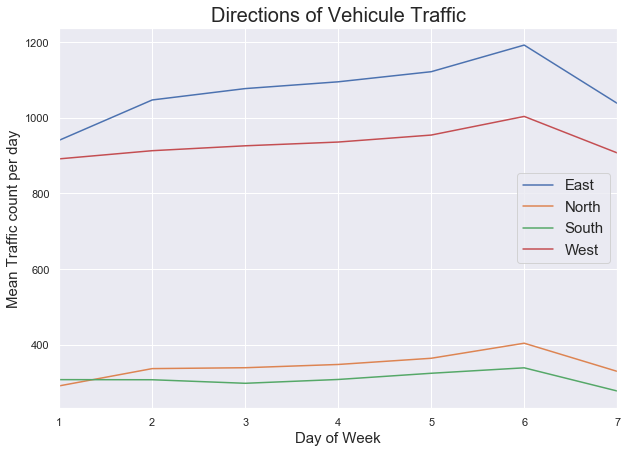

In [945]:
ax = data.pivot_table(index="direction", columns=["dayWeekNo"], 
                      values=["totalVehicles"], aggfunc="mean").T.plot(figsize=(10,7))
ax.set_ylabel('Mean Traffic count per day', fontsize=15)
ax.set_xlabel('Day of Week', fontsize=15)
ax.set_title('Directions of Vehicule Traffic', fontsize=20)
ax.set_xticklabels(range(1,8),rotation=0)
ax.legend(fontsize=15)
None

The highest traffic goes towards East. This is in the direction of downtown Toronto from areas west of GTA (as we saw in the maps shown earlier, the stations which registered this traffic are located west of Toronto). This is no surprise as the central business district is located in this direction. Lesser traffic comes from the westbound into the province, and the least traffic comes from the northern and southern directions.

This traffic distribution also highlights the reality that those living in the northern or southern directions to/from the center of the city may actually experience lesser traffic than those who live in the eastern/western directions from the city center. This assumes heavily that most traffic heads towards the city center.

### Examining Regions

#### Which MTO region registers the highest traffic?

Our hypothesis here would be "Central" since that is where Toronto belong. But we could check in the data?

<img src="picture.png" alt="Drawing" style="width: 700px;"/>

The different MTO regions is displayed above.

In [162]:
data.pivot_table(index="MTORegion", columns=["dayWeekNo"], values=["totalVehicles"], aggfunc="mean")

totalVehicles                                         \
dayWeekNo                1            2            3            4   
MTORegion                                                           
Central        2309.236111  2519.490079  2568.099206  2597.803571   
Eastern         300.456944   312.504167   311.412500   318.884722   
NorthWestern    103.804688    97.927083    96.682292   103.591146   
Northern        186.692460   159.571429   153.571429   158.144841   
Southwestern    389.023438   423.559896   441.510417   453.299479   

                                                     
dayWeekNo               5            6            7  
MTORegion                                            
Central       2644.103175  2763.728175  2504.666667  
Eastern        336.777778   368.441667   286.120833  
NorthWestern   108.184896   124.148438   113.322917  
Northern       166.750000   187.863095   162.654762  
Southwestern   472.726562   509.976562   393.416667

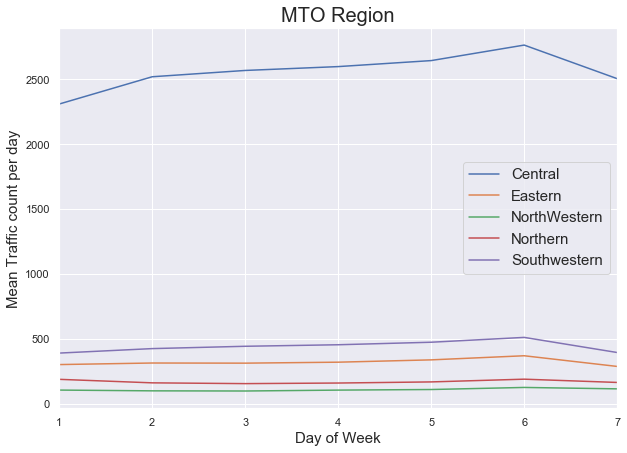

In [163]:
ax = data.pivot_table(index="MTORegion", columns=["dayWeekNo"], 
                      values=["totalVehicles"], aggfunc="mean").T.plot(figsize=(10,7))
ax.set_ylabel('Mean Traffic count per day', fontsize=15)
ax.set_xlabel('Day of Week', fontsize=15)
ax.set_title('MTO Region', fontsize=20)
ax.set_xticklabels(range(1,8),rotation=0)
ax.legend(fontsize=15)
None

For every single day of the week, the central MTO region records the highest traffic. This is no surprise as Toronto belongs here and is the province's financial district. The central region has the highest mean traffic count per day than any other province. Expressed as percentages, we see in the below dataframe that `Central` contributes nearly 70% of the traffic experienced each day in the province. This is indeed very significant. `Southwestern` comes a far second.

We should be able to easily show that this traffic is comprised mostly of `auto`.

In [173]:
round(data.pivot_table(index="MTORegion", columns=["dayWeekNo"], values=["totalVehicles"], aggfunc="mean") * 100 \
/ data.pivot_table(index="MTORegion", columns=["dayWeekNo"], values=["totalVehicles"], aggfunc="mean").sum(axis=0), 3)

totalVehicles                                                
dayWeekNo                1       2       3       4       5       6       7
MTORegion                                                                 
Central             70.206  71.718  71.910  71.531  70.915  69.894  72.385
Eastern              9.135   8.896   8.720   8.781   9.032   9.318   8.269
NorthWestern         3.156   2.788   2.707   2.852   2.902   3.140   3.275
Northern             5.676   4.542   4.300   4.355   4.472   4.751   4.701
Southwestern        11.827  12.057  12.363  12.482  12.679  12.897  11.370

### Examining Days & Hours

#### Which days have the biggest traffic?

In [238]:
round((((data.groupby('dayWeekNo').mean()).iloc[:, 1:4]).T * 100/ 
 (data.groupby('dayWeekNo').mean()).iloc[:, 1:4].sum(axis=1)).T, 2)

,single,multi,auto
dayWeekNo,,,
1,1.34,3.92,94.74
2,3.16,9.87,86.97
3,3.25,10.80,85.95
4,3.25,10.88,85.86
5,3.23,10.45,86.32
6,3.09,8.72,88.19
7,1.87,4.52,93.61


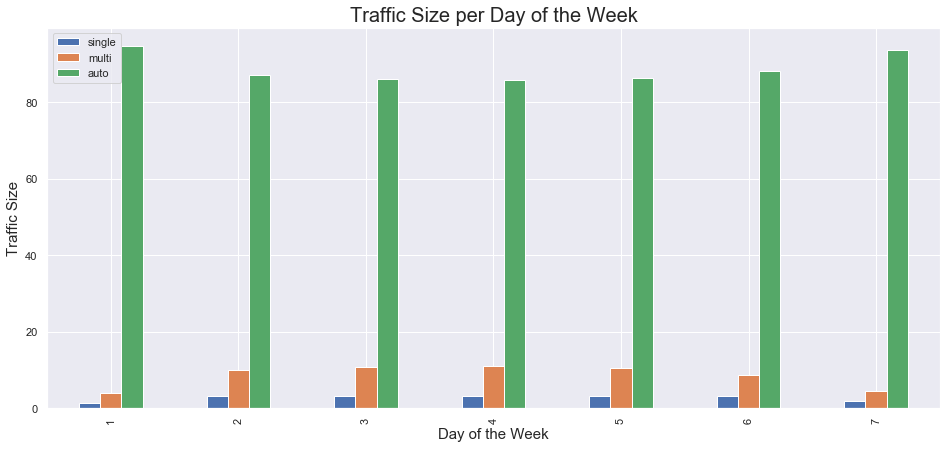

In [252]:
ax = round((((data.groupby('dayWeekNo').mean()).iloc[:, 1:4]).T * 100/ 
 (data.groupby('dayWeekNo').mean()).iloc[:, 1:4].sum(axis=1)).T, 2).plot(kind='bar', figsize=(16,7))
ax.legend(loc='upper left')
ax.set_title('Traffic Size per Day of the Week', fontsize=20)
ax.set_xlabel('Day of the Week', fontsize=15)
ax.set_ylabel('Traffic Size', fontsize=15);

The size of traffic for each day is almost equal. With the exception of the first and last day of the week where traffic is only slightly higher, traffic on other days seems pretty same. Truck traffic also seems significantly lower on these first and last days of the week compared to the other days. This is probably not unconnected to the fact that most commercial business happens in the thick of the weekday.

In this case the raw traffic count offers no more insight than the percentage count.

#### Which hours have the biggest traffic?

Our suspicion this time would be the peak hours of the days, between 11 in the morning and 4 in the evening. But we could take a look at the data.

In [257]:
round((((data.groupby('hour').mean()).iloc[:, 1:4]).T * 100/ 
 (data.groupby('hour').mean()).iloc[:, 1:4].sum(axis=1)).T, 2)

,single,multi,auto
hour,,,
0,2.04,14.48,83.48
1,2.91,19.83,77.26
2,3.58,23.81,72.60
3,4.49,28.13,67.38
4,4.90,27.24,67.86
5,3.97,16.08,79.94
6,3.30,8.67,88.02
7,2.82,6.38,90.81
8,3.09,7.09,89.82


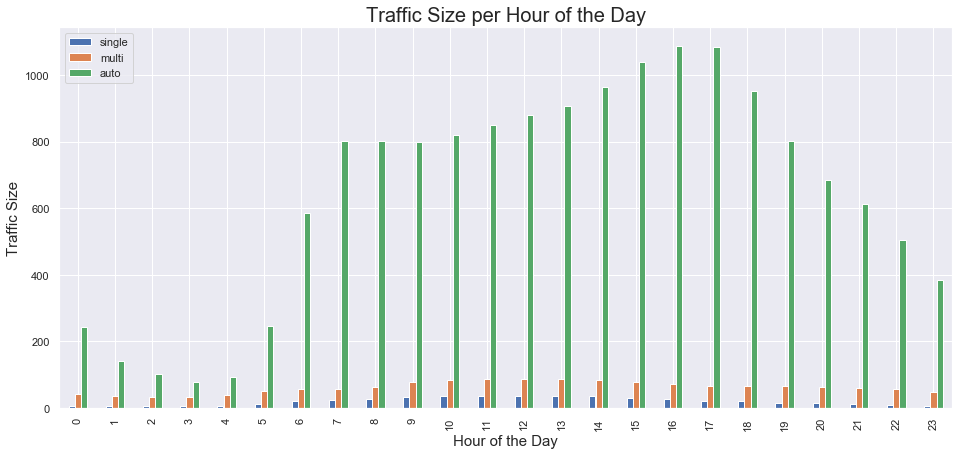

In [260]:
ax = round((data.groupby('hour').mean()).iloc[:, 1:4], 2).plot(kind='bar', figsize=(16,7))
ax.legend(loc='upper left')
ax.set_title('Traffic Size per Hour of the Day', fontsize=20)
ax.set_xlabel('Hour of the Day', fontsize=15)
ax.set_ylabel('Traffic Size', fontsize=15);

The raw counts show significant decrease in traffic during the morning hours between midnight and 5am. As the morning kicks off, traffic starts to increase, before slowing decreasing towards evening. The highet traffic hours are in fact between 3pm and 6pm, apparently during closing hours. While it may look like `totalTrucks` traffic is just as significant as `auto` traffic during the day, the percentage plot below offer a completely different insight.

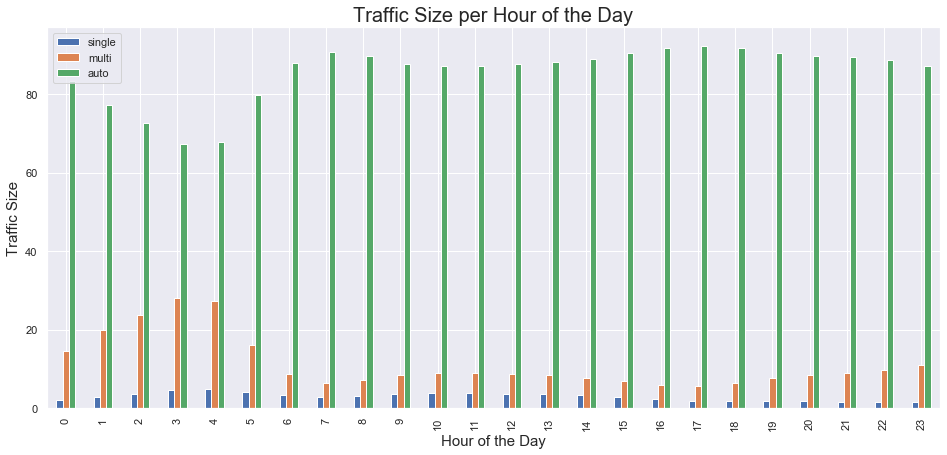

In [248]:
ax = round((((data.groupby('hour').mean()).iloc[:, 1:4]).T * 100/ 
 (data.groupby('hour').mean()).iloc[:, 1:4].sum(axis=1)).T, 2).plot(kind='bar', figsize=(16,7))
ax.legend(loc='upper left')
ax.set_title('Traffic Size per Hour of the Day', fontsize=20)
ax.set_xlabel('Hour of the Day', fontsize=15)
ax.set_ylabel('Traffic Size', fontsize=15);

With the percentage plot we see that the percentage of `auto` plying the roads decreases somewhat in the morning hours. During this time the percentage of `totalTruck` traffic actually increases significantly, confirming the reality that most trucks move during the morning hours between 1 to 5. Clearly, a higher fraction of trucks move during the early morning hours than during the day time. However, for the most part, `auto` or passenger vehicles still dominate traffic.

### Clustering

We attempt to scale and cluster the data set in order to gain some additional insights.

In [128]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [129]:
X = data[['single', 'multi', 'auto', 'totalTrucks']]
Y = data['stationID']

In [964]:
#scale input X values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [741]:
#set color per stationID
x = np.arange(0,104)
x1 = np.repeat(x, 168, axis=0)

In [948]:
Y.loc[1:len(Y):168].head()

1      ON0016
169    ON0017
337    ON0018
505    ON0019
673    ON0020
Name: stationID, dtype: object

In [966]:
#apply kmeans to generate a cluster of 10
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

In [967]:
y_kmeans[:40]

array([6, 0, 0, 0, 0, 6, 6, 6, 9, 4, 4, 8, 8, 8, 8, 8, 2, 8, 8, 8, 8, 4,
       4, 6, 6, 0, 0, 0, 6, 4, 8, 8, 4, 4, 4, 4, 4, 4, 4, 4])

In [968]:
pd.concat([Y,pd.Series(y_kmeans)],axis=1).head()

,stationID,0
0,ON0016,6
1,ON0016,0
2,ON0016,0
3,ON0016,0
4,ON0016,0


In [954]:
X.head()

,single,multi,auto,totalTrucks
0,7,31,302,38
1,9,22,170,31
2,0,23,124,23
3,9,31,85,40
4,9,27,114,36


First, we plot `totalTrucks` data on the y-axis against the other attributes and attempt pairwise comparison for all the groups.

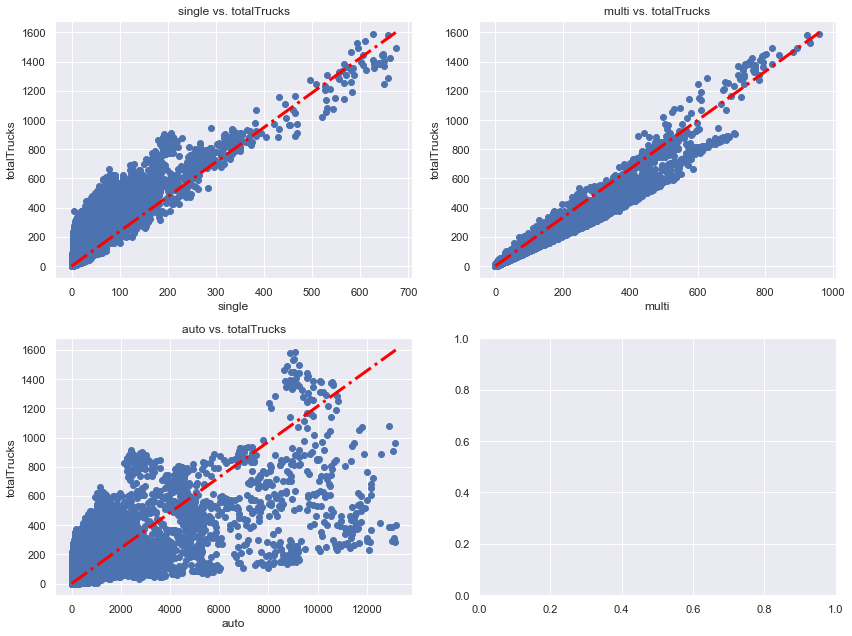

In [151]:
fig, ax = plt.subplots(2, 2, figsize=(12,9))
for i,attrb in enumerate(['single', 'multi', 'auto']):
    ax[i//2,i%2].scatter(X[attrb], X['totalTrucks'])

    ax[i//2,i%2].set(xlabel=attrb,
                     ylabel='totalTrucks', 
                     title=attrb+' vs. totalTrucks')
    x = np.linspace(0,max(X[attrb]),50)
    y = np.linspace(0,1600,50)
    ax[i//2,i%2].plot(x,y, linewidth=3, linestyle="-.", color='red')
    
plt.tight_layout()

`totalTrucks` is the sum of single and multi-unit trucks. The scatter plot appears to suggest that when there are lesser numbers of `totalTrucks` on the road, they are mostly `multi` trucks. The scatter plot `multi vs. totalTrucks` has nearly a slope of 1 at lower values. This suggests that the number of `totalTrucks` is almost as much as the number of `multi`. As a result, one can infer that there are more `multi` unit trucks on Ontario roads than there are `single` unit trucks.

The `auto vs. totalTrucks` scatter plot offers better insight. Clearly, there are many more `auto` than there are other vehicles. At areas of high `auto` density, it appears traffic of `totalTrucks` is low. This is because there are more scatter points on the south side of the plot than there are on the north end. Again, we see here that overall, there are fewer locations where traffic is dense. Most traffic in the province is light. This is seen on the scatter plot in the clustering of most points at lower values of `auto` and `totalTrucks`.

Before applying `kmeans` clustering, we generate first a scatter plot where the points are colored based on `stationID`. We see here that areas of low traffic are clustered together, while areas of high traffic are a little spread apart. Many of the areas of low traffic overlap each other. It would seem that areas of high traffic do not interfere significantly with areas of lower traffic. 

Areas of high traffic also seem to have `totalTrucks` and `auto` in near equal measure. This could suggest that passenger vehicles and trucks contribute near equal traffic in the province.

We do have to realize here that colors will be distributed about the plot, because areas of low traffic is mixed in with areas of high traffic. The plot has been colored per `stationID`.

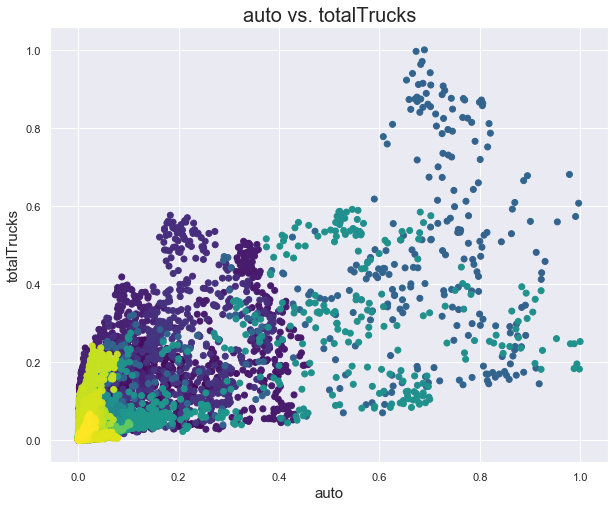

In [971]:
plt.figure(figsize=(10,8))
plt.scatter(X_scaled[:,2], X_scaled[:,3], c=x1, cmap='viridis')
plt.xlabel('auto', fontsize=15)
plt.ylabel('totalTrucks', fontsize=15)
plt.title('auto vs. totalTrucks', fontsize=20)
plt.show()

Below, we show the scatter plot colored based on cluster number. `kmeans` does appear to have done an excellent job in correctly clustering the data set into regions from very low traffic to rather high traffic. Lower traffic regions are closer to the origin, while higher traffic regions are away from the origin. We could probably proceed from here by applying a label to each of the record. This could be used in a classification task to predict traffic volume in the future if provided with new data set.

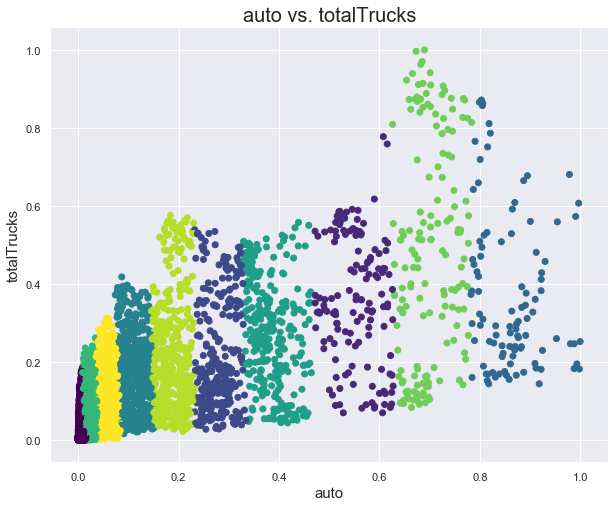

In [970]:
plt.figure(figsize=(10,8))
plt.scatter(X_scaled[:,2], X_scaled[:,3], c=y_kmeans, cmap='viridis')
plt.xlabel('auto', fontsize=15)
plt.ylabel('totalTrucks', fontsize=15)
plt.title('auto vs. totalTrucks', fontsize=20)
plt.show()

### Forecasting

Next, we attempt to forecast traffic on the busiest highway, `Hwy 401`, using the time series data available. We will use a simple `fft` algorithm for this task. This is available in `numpy`.

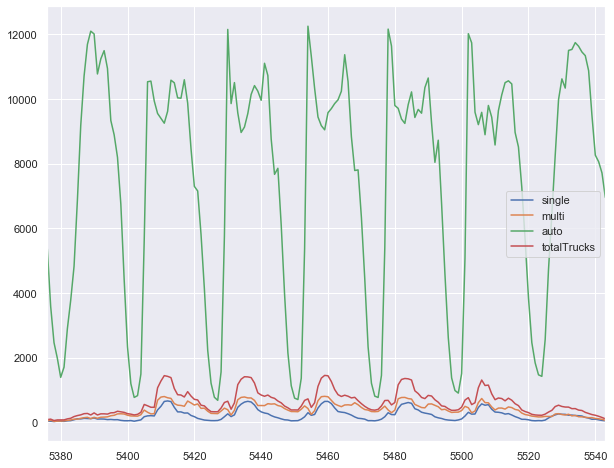

In [972]:
data[['single', 'multi', 'auto', 'totalTrucks']][data['stationID']=='ON0115'].plot(figsize=(10,8))
None

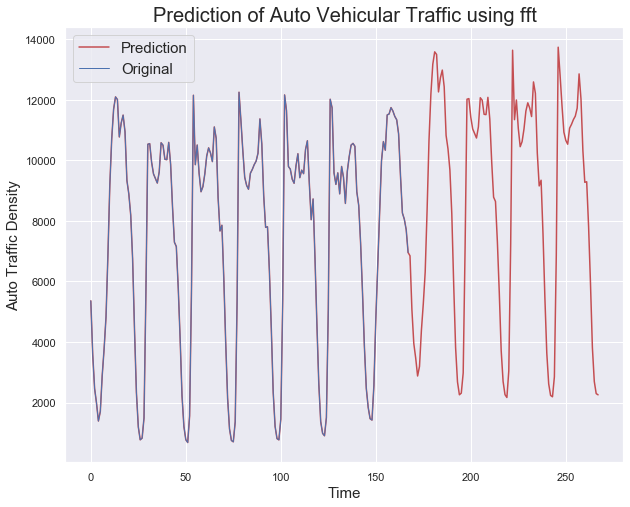

In [984]:

# We will attempt to predict 100 units into the future using only the
# auto attribute
auto = data[['single', 'multi', 'auto', 'totalTrucks']][data['stationID']=='ON0115'].auto
auto_predict = 100
n = auto.size

harmonics = 10
t = np.arange(0,n)
p = np.polyfit(t, auto, 1)
auto_notrend = auto - p[0] * t
auto_freqdom = np.fft.fft(auto_notrend)
f = np.fft.fftfreq(n)

indexes = range(n)
list(indexes).sort(key = lambda i: np.absolute(f[i]))

plt.figure(figsize=(10,8))

t = np.arange(0, n+auto_predict)
new_auto = np.zeros(t.size)

for i in indexes[:1 + harmonics*20]:
    ampli = np.absolute(auto_freqdom[i]) / n
    phase = np.angle(auto_freqdom[i])
    new_auto += ampli * np.cos(2 * np.pi * f[i] * t + phase)
new_auto = new_auto + p[0] * t
plt.plot(np.arange(0, new_auto.size), new_auto, 'r', label='Prediction')
plt.plot(np.arange(0, auto.size), x, 'b', label='Original', linewidth = 1)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Auto Traffic Density', fontsize=15)
plt.legend(fontsize=15, loc='upper left')
plt.title('Prediction of Auto Vehicular Traffic using fft', fontsize=20)
plt.show()

It is not unexpected that we obtain a repetition of past values. `fft` seems quite suitable for this prediction. Vehicular traffic will almost always follow this pattern, except on unusual days during which other external factors may affect vehicle traffic.

### Conclusion

After examining the available data set, we were able to derive some key insights. Some of the biggest traffic in the province happen on `Hwy 401`, `QEW` and `King Edward Ave`. While these may have the highest density of cars and other passenger vehicles, they do not feature among the list of highways which carry truck traffic. These highways, which have the biggest truck traffic, are much closer to the border of the province than they are to the city center. We also found that passenger vehicle traffic consititute the biggest traffic in the province. More passengers move in the province than do goods. While most traffic happen towards the province's financial district of Toronto, other areas outside of Toronto also have traffic which is just as significant, for example `QEW` around Hamilton. However, the highest traffic is towards the east. This could also be because of the location of the city's financial district with respect to all other locations. The northern and southern directions carry the least traffic.

We also found something curious about the time plot for highway `Hwy 401`. Though traffic begins to increase at around 5am and peaks at noon, it appears that for the first and last day of the week, the slopes are much gentler than during the other days of the week. Could this suggest some lethargy preventing people from hurrying to work on a Monday and more people relaxing at home on the weekends compared to other busy days of the week? The other denser highway traffic on `QEW` and `King Edward Ave` also follow this trend. Traffic on the last day of the week also did not peter out in the evening as does traffic on other days, possibly suggesting that more people spent longer nights out during the last day of the week?

Clustering offers an avenue to cluster the data set into areas of high, low or medium traffic based on the size of the traffic for any given hour in a day. This generates an output that could help with labeling the data set and with which further classification could be done if provided with new data set.

Finally, we predicted some future traffic on the biggest highway using `fft`. The easy predicatability of traffic patterns makes `fft` a suitable method for this job, as it can easily duplicate the repetitive changes.

### Limitations

Unfortunately, some of the conclusions derived from this data is limited. This is because the data set only offers a week of data. Even though the data set is dense enough to derive quality insights, it is still limited in its span. Were it available over several months or years, it would most certainly have enabled better quality insights in its analysis.

In addition, the non-availability of GPS coordinates in the original data set greatly limited what could be achieved in terms of analysis. A good recommendation would be to include this in subsequent provisions of future data set of this kind. GPS coordinates for traffic data are some of the most indispensable attributes which offer better analysis potential.

### References

Ontario MTO (2019).  _2006 Commercial Vehicle Survey: traffic volumes at survey stations_ (data set available https://data.ontario.ca/dataset/2006-commercial-vehicle-survey-traffic-volumes-at-survey-stations).

Jake VanderPlas (2016).  _Python Data Science Handbook_ (available at https://jakevdp.github.io/PythonDataScienceHandbook/). O'Reilly.